# Лабораторная работа 5.
## «Моделирование и прогнозирование временных рядов»

**Задание**: имеется временной ряд производства скота и птицы на убой в живом весе (тыс.тонн) в Псковской области за 2000-2022 гг.

**Требуется**: 

1. Провести графиеский анализ временного

2. Моделирование и прогнозирование уровней временного ряда.

**Этапы выполнения задания:**

1. Выполнить декомпозицию задач.

2. Загрузить файл, импортировать основные библиотеки, изучить общую информацию о временном ряде.

3. Провести анализ временного ряда, предобработку данных

4. Выполнить сглаживание временного ряда для разных порядков сглаживания.

5. Выполнить декомпозицию временного ряда в аддитивной и мультипликативной формах.

6. Построить краткострочный прогноз на основе тройного сглаживания Хольта.

7. Выделить основные компоненты временного ряда.

8. Построить ряд, очищенный от сезонности, проверить ряд на стационарность.

9. Построить стационарный ряд, используя оператор последовательных разностей (дифференцирование ряда).

10. Построить ARIMA-модель, обосновать параметры выбора модели.

11. Провести графический анализ фактических, модельных значений, анализ остатков модели.

12. Построить прогнозы.

## 1. Выполнить декомпозицию задач.

### Содержание:

* [2. Загрузить файл, импортировать основные библиотеки, изучить общую информацию о временном ряде.](#2)

* [3. Провести анализ временного ряда, предобработку данных.](#3)

* [4. Выполнить сглаживание временного ряда для разных порядков сглаживания.](#4)

* [5. Выполнить декомпозицию временного ряда в аддитивной и мультипликативной формах.](#5)

    * [5.1. Аддитивная форма.](#5.1)
      
    * [5.2. Мультипликативная форма.](#5.2)

* [6. Построить краткострочный прогноз на основе тройного сглаживания Хольта.](#6)

* [7. Выделить основные компоненты временного ряда.](#7)

* [8. Построить ряд, очищенный от сезонности, проверить ряд на стационарность.](#8)

* [9. Построить стационарный ряд, используя оператор последовательных разностей (дифференцирование ряда).](#9)

* [10. Построить ARIMA-модель, обосновать параметры выбора модели.](#10)

* [11. Провести графический анализ фактических, модельных значений, анализ остатков модели.](#11)

* [12. Построить прогнозы.](#12)

    * [12.1. Использование библиотеки sktime.](#12.1)

## 2. Загрузить файл, импортировать основные библиотеки, изучить общую информацию о временном ряде. <a class="anchor" id="2"></a>

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
from math import sqrt
from datetime import timedelta

import matplotlib.pyplot as plt
from pylab import rcParams

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from scipy import signal

from sklearn.metrics import mean_squared_error

from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.sarimax import SARIMAX
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import AutoARIMA
from sktime.performance_metrics.forecasting import mean_squared_error, geometric_mean_squared_error
from sktime.utils.plotting import plot_series

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Загрузка и просмотр датасета
# сразу превратим дату в индекс и преобразуем ее в datetime
df = pd.read_excel("./data/Cattle_Pscov.xlsx", index_col='date', parse_dates=True)
df.head()

cattle
date              
2000-01-01     3.0
2000-02-01     2.8
2000-03-01     2.7
2000-04-01     3.1
2000-05-01     3.3

## 3. Провести анализ временного ряда, предобработку данных. <a class="anchor" id="3"></a>

In [3]:
# Просмотр информацию о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 275 entries, 2000-01-01 to 2022-11-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   cattle  275 non-null    float64
dtypes: float64(1)
memory usage: 4.3 KB


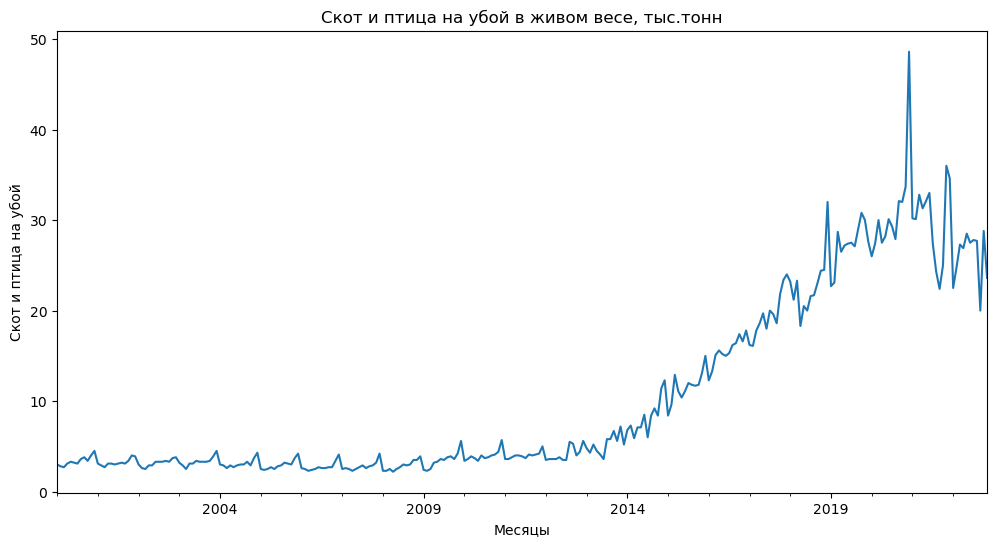

In [4]:
# Построение графика временного ряда
ax = df["cattle"].plot(figsize=(12, 6), legend=None)
ax.set(title="Скот и птица на убой в живом весе, тыс.тонн", xlabel="Месяцы", ylabel="Скот и птица на убой")
plt.show()

In [5]:
# Вывод описательной статистики
df.describe()

cattle
count  275.000000
mean    10.389455
std     10.159372
min      2.200000
25%      3.100000
50%      4.000000
75%     17.800000
max     48.600000

In [6]:
# Нахождение аномального значения
anomaly_index = df.index[df['cattle'] == df['cattle'].max()].tolist()[0]
anomaly_index

Timestamp('2020-12-01 00:00:00')

In [7]:
# Сглаживание методом усреднения
df["cattle"][anomaly_index] = (df["cattle"][anomaly_index - timedelta(days=366)] + df["cattle"][anomaly_index + timedelta(days=365)]) / 2

In [8]:
# Проверка что значение сгладилось
df["cattle"][anomaly_index]

31.1

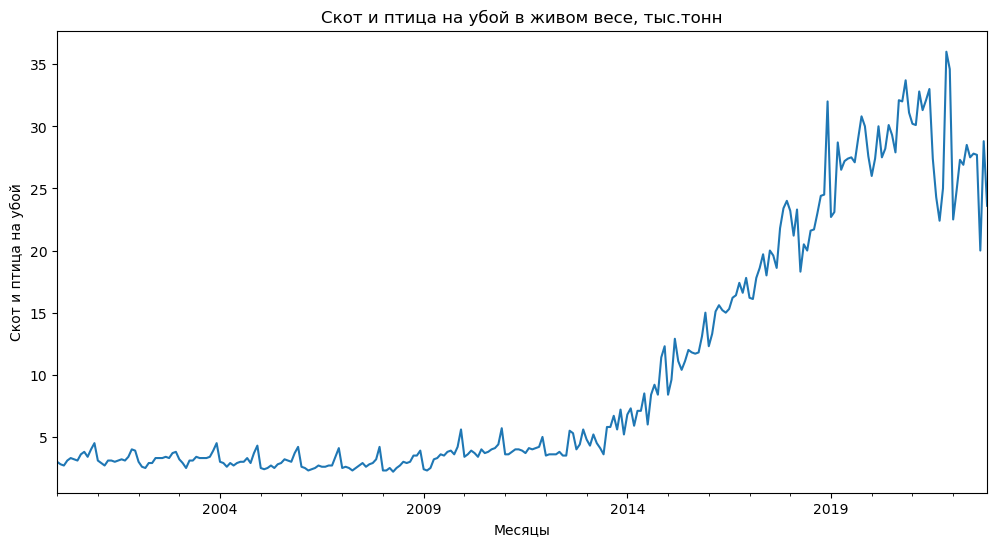

In [9]:
# Графическое подтверждение что аномалия сглажена
ax = df["cattle"].plot(figsize=(12, 6), legend=None)
ax.set(title="Скот и птица на убой в живом весе, тыс.тонн", xlabel="Месяцы", ylabel="Скот и птица на убой")
plt.show()

## 4. Выполнить сглаживание временного ряда для разных порядков сглаживания. <a class="anchor" id="4"></a>

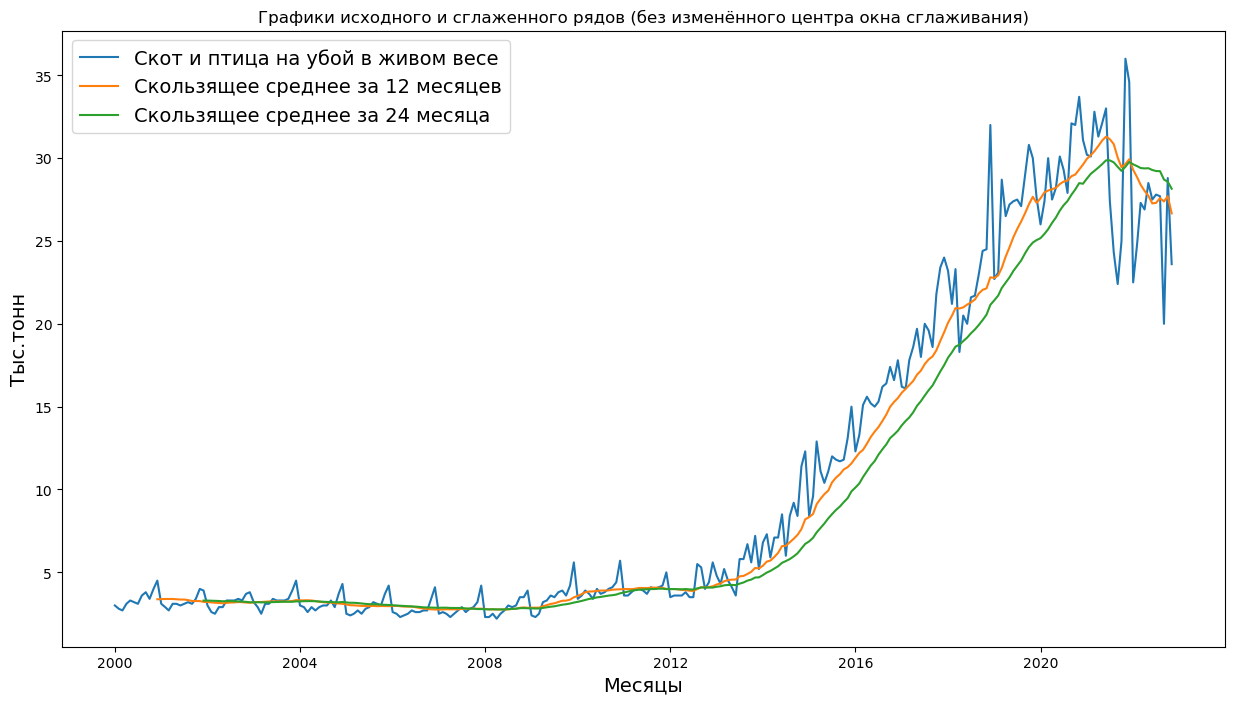

In [10]:
plt.figure(figsize = (15,8))
plt.plot(df, label='Скот и птица на убой в живом весе')
plt.plot(df.rolling(12).mean(), label='Скользящее среднее за 12 месяцев')
plt.plot(df.rolling(24).mean(), label='Скользящее среднее за 24 месяца')
plt.legend(title = '', loc = 'upper left', fontsize = 14)
plt.xlabel('Месяцы', fontsize = 14)
plt.ylabel('Тыс.тонн', fontsize = 14)
plt.title("Графики исходного и сглаженного рядов (без изменённого центра окна сглаживания)")
plt.show()

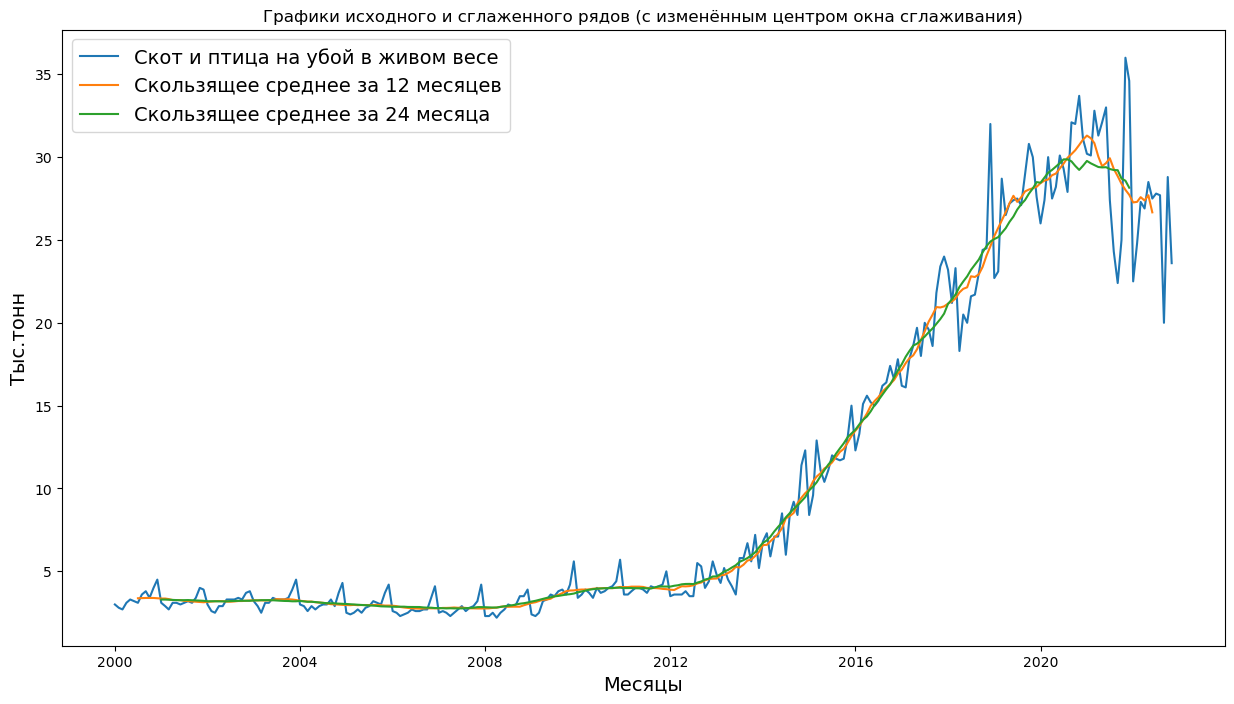

In [11]:
plt.figure(figsize = (15,8))
plt.plot(df, label='Скот и птица на убой в живом весе')
plt.plot(df.rolling(12, center=True).mean(), label='Скользящее среднее за 12 месяцев')
plt.plot(df.rolling(24, center=True).mean(), label='Скользящее среднее за 24 месяца')
plt.legend(title = '', loc = 'upper left', fontsize = 14)
plt.xlabel('Месяцы', fontsize = 14)
plt.ylabel('Тыс.тонн', fontsize = 14)
plt.title("Графики исходного и сглаженного рядов (с изменённым центром окна сглаживания)")
plt.show()

## 5. Выполнить декомпозицию временного ряда в аддитивной и мультипликативной формах. <a class="anchor" id="5"></a>

**Коррелограмма выборочной автокорреляционной функции:**
$$\hat{\rho}(\tau) = \frac{\bar{y}_{t}\bar{y}_{t+\tau}-\bar{y}_{t}\cdot\bar{y}_{t+\tau}}{\hat{\sigma}_{y_{t}}\hat{\sigma}_{y_{t+\tau}}}$$

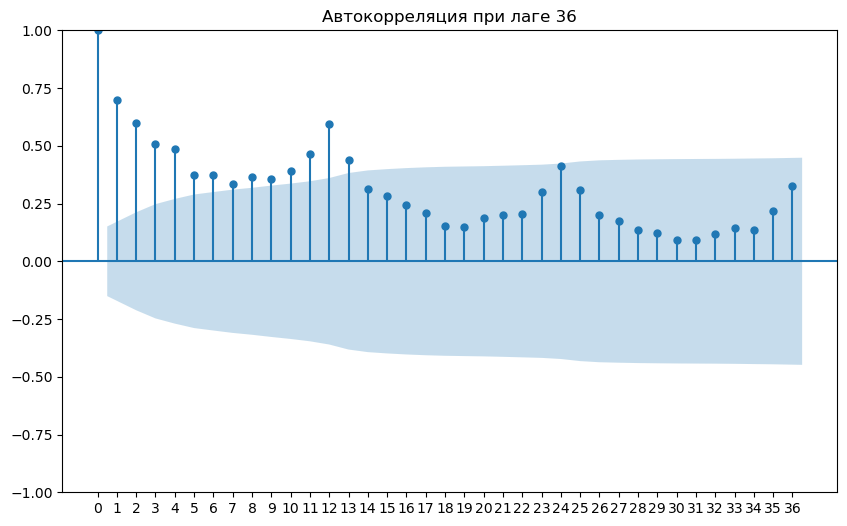

In [12]:
rcParams['figure.figsize'] = 10, 6
plot_acf(df[:"2014-01-01"], lags=36)
plt.xticks(ticks=range(37))
plt.title("Автокорреляция при лаге 36")
plt.show()

**Выводы (при срезе):**

* Автокорреляция позволяет выявлять тренд и сезонность. Заметим, что лаг 12 сильнее коррелирует с исходным рядом, чем соседние лаги 11 и 13. То же самое можно сказать и про лаги 24 и 36. Такая автокорреляция позволяет предположить наличие ежегодных сезонных колебаний.

* Постоянно положительная корреляция говорит о наличии тренда.

* Если столбец выходит за пределы синей границы, то автокорреляция достаточно сильна.

* Вывод по структуре временного ряда: временной ряд имеет тренд, а также сильную автокорреляцию при лаге 12, что говорит о сезонности равной 12 месяцам (ежегодной)

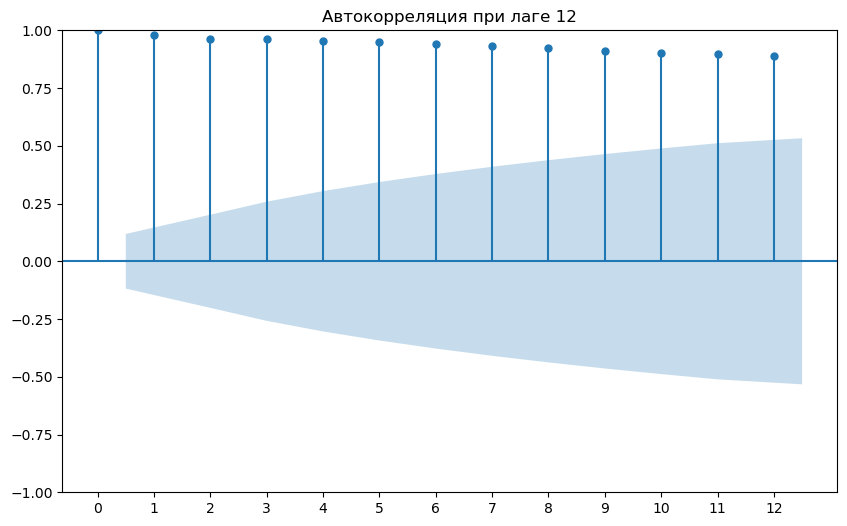

In [13]:
plot_acf(df, lags=12)
plt.xticks(ticks=range(13))
plt.title("Автокорреляция при лаге 12")
plt.show()

**Если не делать срез, то по коррелолограмме нельзя сказать о наличии сезонности, зато можно сказать о наличии тренда и очень сильной корреляционной связи**

### Аддитивная форма <a class="anchor" id="5.1"></a>

**Выделим компоненты временного ряда**

**Построим аддитивную модель ряда по форме:**

$$y_{t}=T_{t}+S_{t}+\varepsilon_{t} \textrm{, где}\quad T_{t}\textrm{- тренд,}\quad S_{t}\textrm{ - сезонная компонента,}\quad \varepsilon_{t}\textrm{ - случайная компонента}\quad$$

In [14]:
decompose_add = seasonal_decompose(df, period=12, model='additive', extrapolate_trend='freq')

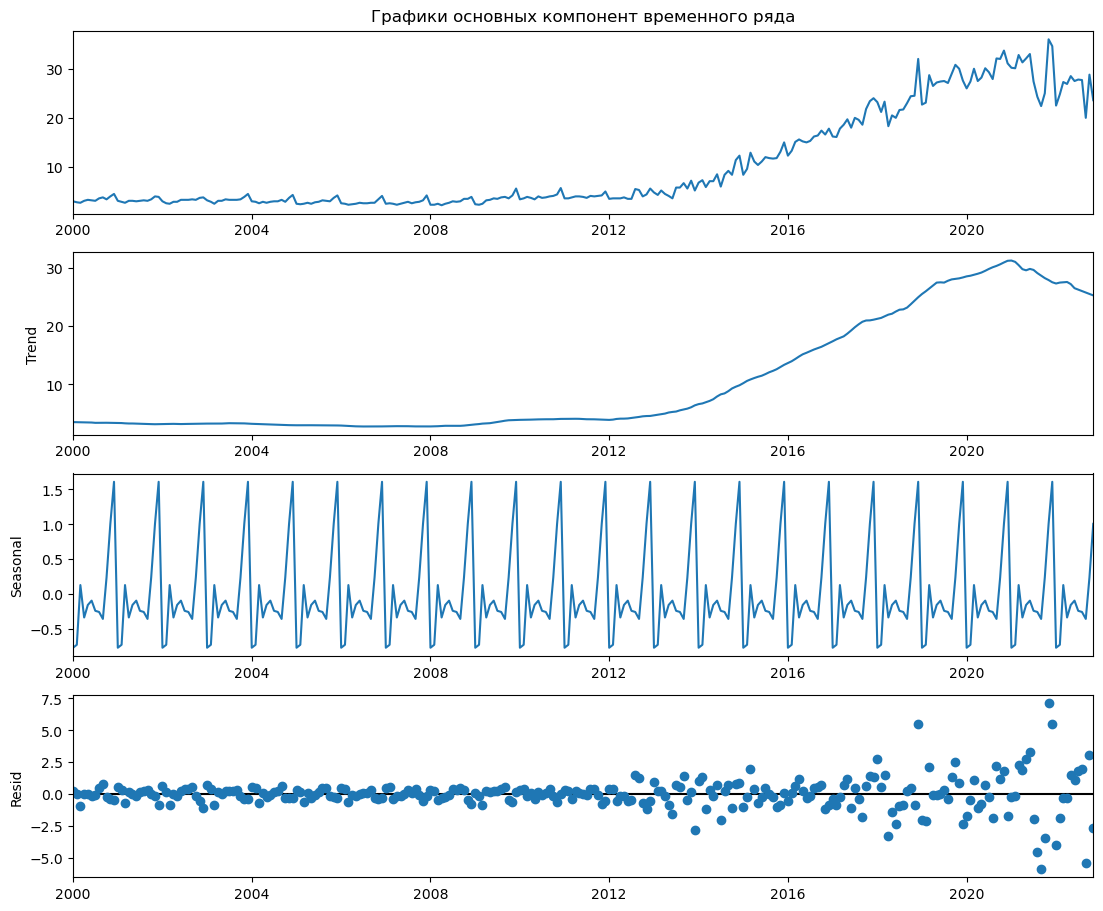

In [15]:
rcParams['figure.figsize'] = 11, 9
decompose_add.plot()
plt.title("Графики основных компонент временного ряда", pad=485)
plt.show()

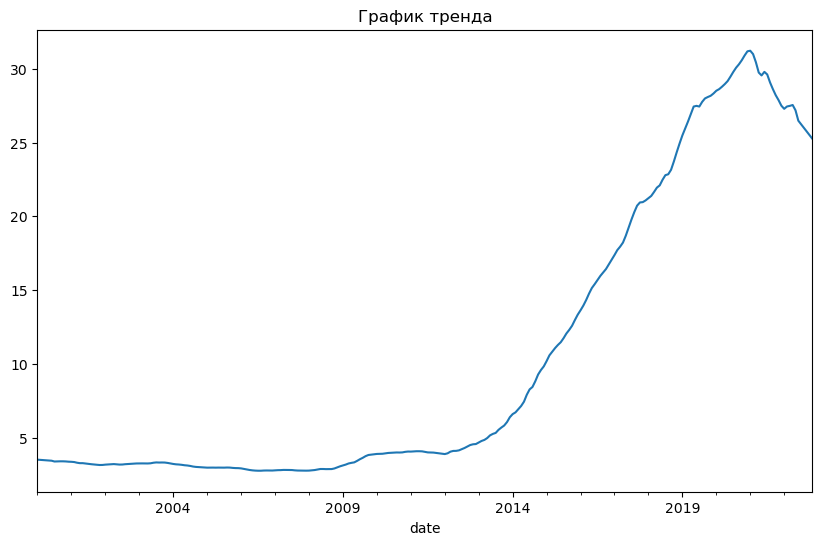

In [16]:
rcParams['figure.figsize'] = 10, 6
decompose_add.trend.plot()
plt.title("График тренда")
plt.show()

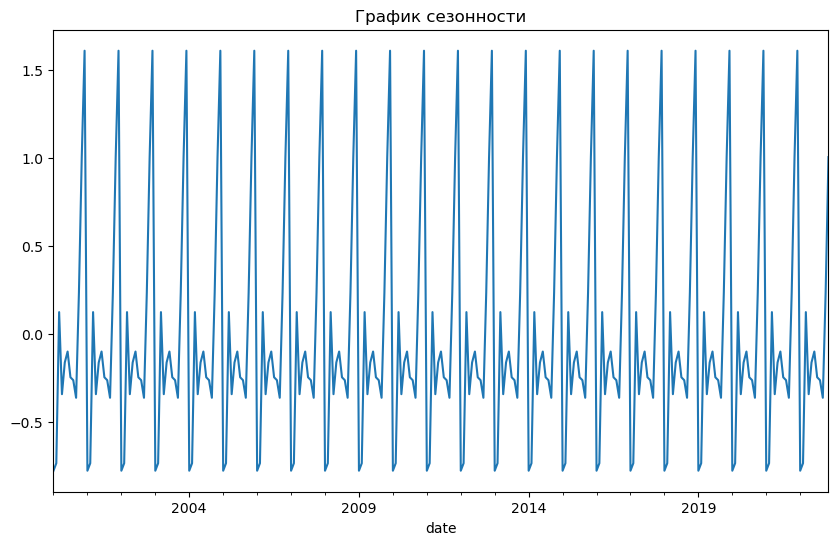

In [17]:
rcParams['figure.figsize'] = 10, 6
decompose_add.seasonal.plot()
plt.title("График сезонности")
plt.show()

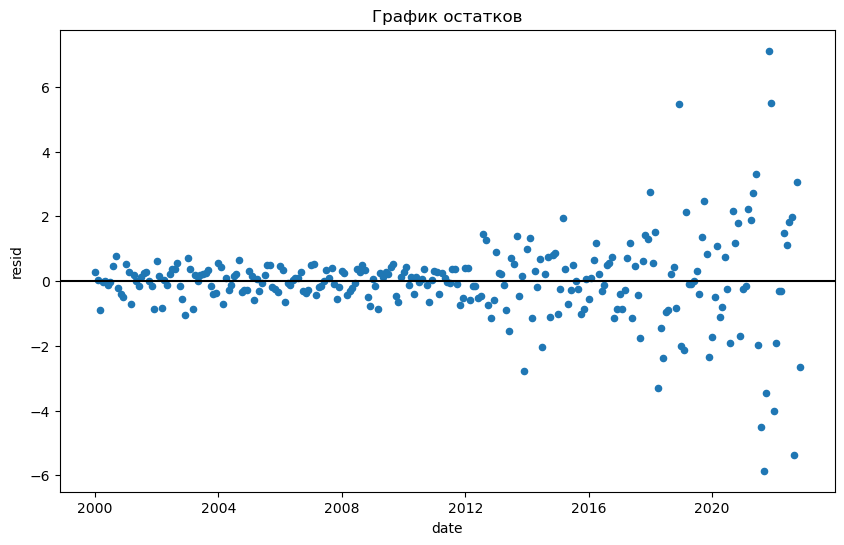

In [18]:
rcParams['figure.figsize'] = 10, 6
decompose_add.resid.reset_index().plot.scatter(x="date", y="resid")
plt.axhline(0, color="black")
plt.title("График остатков")
plt.show()

In [19]:
# Вывод компонент
pd.concat([decompose_add.trend, decompose_add.seasonal, decompose_add.resid], axis=1).reset_index().set_index("date")

trend  seasonal     resid
date                                     
2000-01-01   3.503594 -0.775487  0.271893
2000-02-01   3.489302 -0.732837  0.043535
2000-03-01   3.475010  0.125212 -0.900222
2000-04-01   3.460718 -0.340833 -0.019885
2000-05-01   3.446426 -0.160864  0.014438
...               ...       ...       ...
2022-07-01  26.231561 -0.244819  1.813258
2022-08-01  25.984620 -0.261437  1.976817
2022-09-01  25.737680 -0.361208 -5.376472
2022-10-01  25.490739  0.235760  3.073500
2022-11-01  25.243799  1.005555 -2.649353

[275 rows x 3 columns]

In [20]:
# Формирование отдельного датасета с компонентами
df_decompose_add = pd.concat([decompose_add.observed, decompose_add.seasonal, decompose_add.trend, decompose_add.resid], axis=1)
df_decompose_add.columns = ['actual_values', 'seasonal', 'trend', 'resid']
df_decompose_add.head()

actual_values  seasonal     trend     resid
date                                                   
2000-01-01            3.0 -0.775487  3.503594  0.271893
2000-02-01            2.8 -0.732837  3.489302  0.043535
2000-03-01            2.7  0.125212  3.475010 -0.900222
2000-04-01            3.1 -0.340833  3.460718 -0.019885
2000-05-01            3.3 -0.160864  3.446426  0.014438

### Мультипликативная форма <a class="anchor" id="5.2"></a>

**Выделим компоненты временного ряда**

**Построим мультипликативную модель ряда по форме:**

$$y_{t}=T_{t}\cdot S_{t}\cdot\varepsilon_{t} \textrm{, где}\quad T_{t}\textrm{- тренд,}\quad S_{t}\textrm{ - сезонная компонента,}\quad \varepsilon_{t}\textrm{ - случайная компонента}\quad$$

In [21]:
decompose_mult = seasonal_decompose(df, period=12, model='multiplicative', extrapolate_trend='freq')

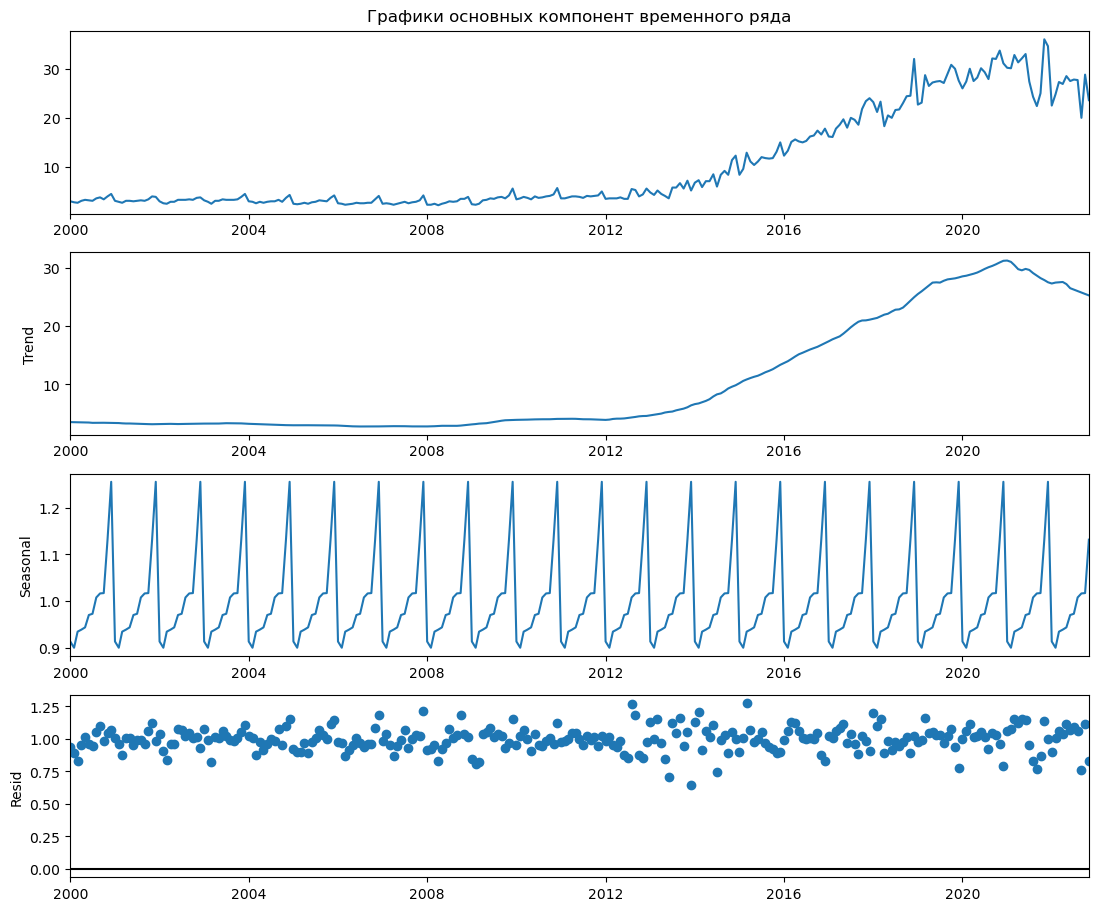

In [22]:
rcParams['figure.figsize'] = 11, 9
decompose_mult.plot()
plt.title("Графики основных компонент временного ряда", pad=485)
plt.show()

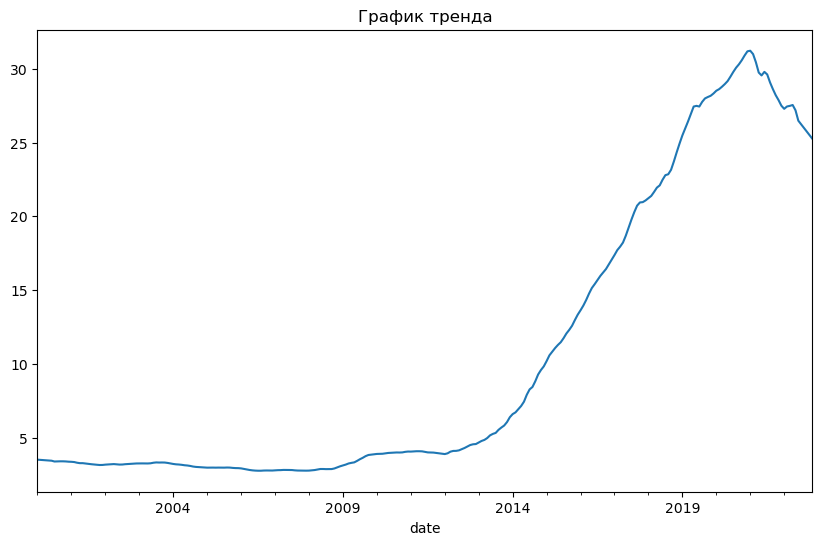

In [23]:
rcParams['figure.figsize'] = 10, 6
decompose_mult.trend.plot()
plt.title("График тренда")
plt.show()

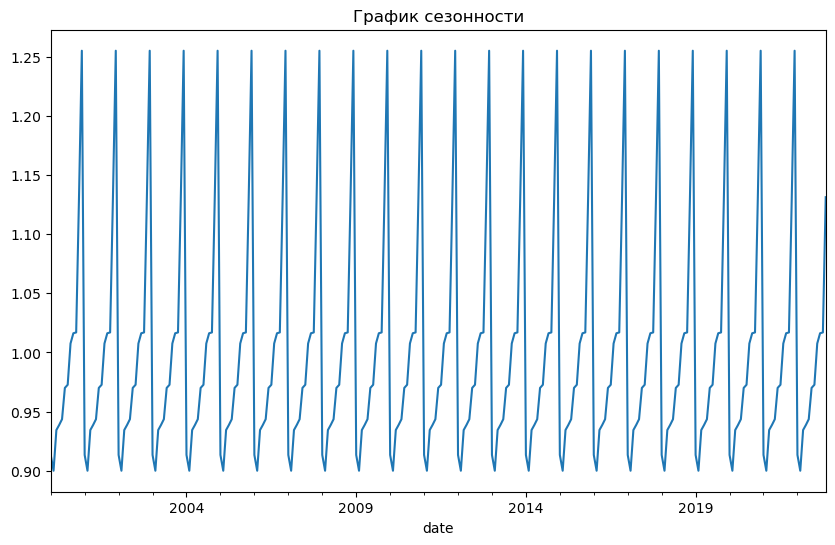

In [24]:
rcParams['figure.figsize'] = 10, 6
decompose_mult.seasonal.plot()
plt.title("График сезонности")
plt.show()

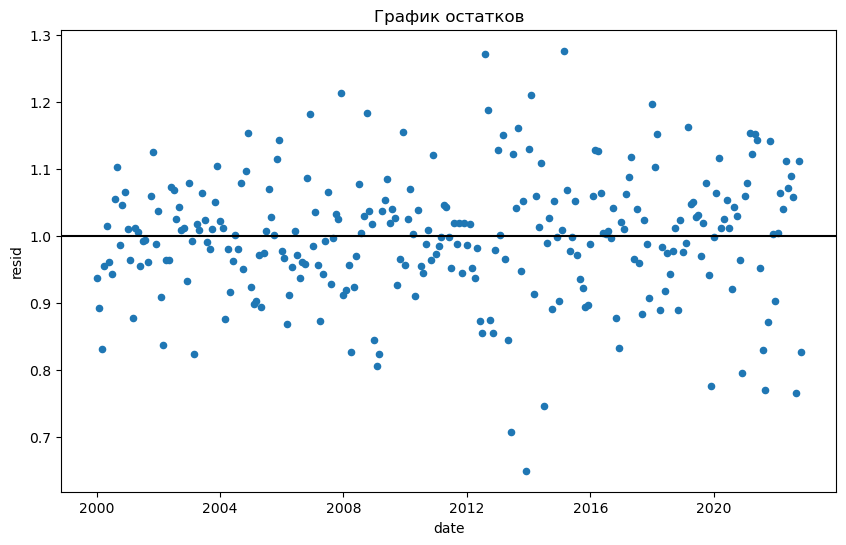

In [25]:
rcParams['figure.figsize'] = 10, 6
decompose_mult.resid.reset_index().plot.scatter(x="date", y="resid")
plt.axhline(1, color="black")
plt.title("График остатков")
plt.show()

In [26]:
# Вывод компонент
pd.concat([decompose_mult.trend, decompose_mult.seasonal, decompose_mult.resid], axis=1).reset_index().set_index("date")

trend  seasonal     resid
date                                     
2000-01-01   3.503594  0.913370  0.937477
2000-02-01   3.489302  0.900027  0.891587
2000-03-01   3.475010  0.934417  0.831509
2000-04-01   3.460718  0.938754  0.954209
2000-05-01   3.446426  0.943578  1.014769
...               ...       ...       ...
2022-07-01  26.231561  0.972701  1.089535
2022-08-01  25.984620  1.007577  1.057999
2022-09-01  25.737680  1.016233  0.764658
2022-10-01  25.490739  1.016941  1.111001
2022-11-01  25.243799  1.131274  0.826399

[275 rows x 3 columns]

In [27]:
# Формирование отдельного датасета с компонентами
df_decompose_mult = pd.concat([decompose_mult.observed, decompose_mult.seasonal, decompose_mult.trend, decompose_mult.resid], axis=1)
df_decompose_mult.columns = ['actual_values','seasonal', 'trend', 'resid']
df_decompose_mult.head()

actual_values  seasonal     trend     resid
date                                                   
2000-01-01            3.0  0.913370  3.503594  0.937477
2000-02-01            2.8  0.900027  3.489302  0.891587
2000-03-01            2.7  0.934417  3.475010  0.831509
2000-04-01            3.1  0.938754  3.460718  0.954209
2000-05-01            3.3  0.943578  3.446426  1.014769

## 6. Построить краткострочный прогноз на основе тройного сглаживания Хольта. <a class="anchor" id="6"></a>

**Тройное экспоненциальное сглаживание - это расширение экспоненциального сглаживания, которое добавляет сезонность в одномерный временной ряд с тенденцией.**

In [28]:
# Инициализация и прогнозирование модели экспоненциального сглаживания Холта Винтера (HWES).
model_EMA = ExponentialSmoothing(df, seasonal_periods=12, trend='add', seasonal='add').fit()
y_pred_EMA = model_EMA.forecast(6)
print(y_pred_EMA)
model_EMA.summary()

2022-12-01    26.365479
2023-01-01    23.645196
2023-02-01    23.351513
2023-03-01    23.859024
2023-04-01    23.045990
2023-05-01    22.886327
Freq: MS, dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                       ExponentialSmoothing Model Results                       
================================================================================
Dep. Variable:                   cattle   No. Observations:                  275
Model:             ExponentialSmoothing   SSE                            614.108
Optimized:                         True   AIC                            252.935
Trend:                         Additive   BIC                            310.803
Seasonal:                      Additive   AICC                           255.607
Seasonal Periods:                    12   Date:                 Fri, 13 Jan 2023
Box-Cox:                          False   Time:                         11:24:31
Box-Cox Coeff.:                    None                                         
=================================================================================
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1652969                alpha                 True
smoothing_trend               0.1426505                 beta                 True
smoothing_seasonal           2.3263e-12                gamma                 True
initial_level                 3.4711075                  l.0                 True
initial_trend                -0.0122928                  b.0                 True
initial_seasons.0            -0.7653908                  s.0                 True
initial_seasons.1            -0.7174320                  s.1                 True
initial_seasons.2             0.1317207                  s.2                 True
initial_seasons.3            -0.3396720                  s.3                 True
initial_seasons.4            -0.1576937                  s.4                 True
initial_seasons.5            -0.0919209                  s.5                 True
initial_seasons.6            -0.2379949                  s.6                 True
initial_seasons.7            -0.2654863                  s.7                 True
initial_seasons.8            -0.3656934                  s.8                 True
initial_seasons.9             0.2352883                  s.9                 True
initial_seasons.10            1.0113824                 s.10                 True
initial_seasons.11            1.6132514                 s.11                 True
---------------------------------------------------------------------------------
"""

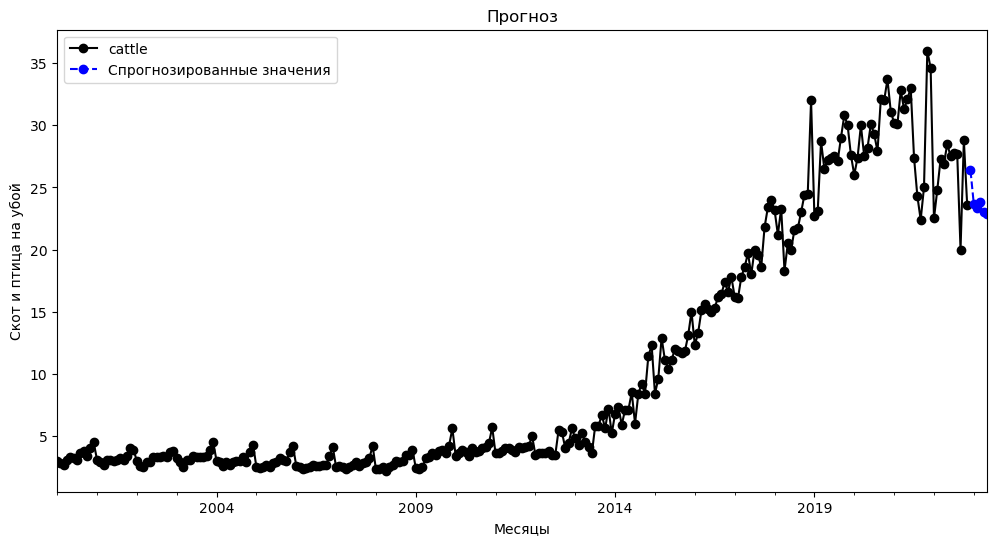

In [29]:
# Графический вывод прогноза.
ax = df.plot(figsize=(12, 6), marker='o', color='black', title="Прогноз")
ax.set_ylabel('Скот и птица на убой')
ax.set_xlabel('Месяцы')
model_EMA.forecast(6).rename('Спрогнозированные значения').plot(ax=ax, style='--', marker='o', color='blue', legend=True)
plt.show()

## 7. Выделить основные компоненты временного ряда. <a class="anchor" id="7"></a>

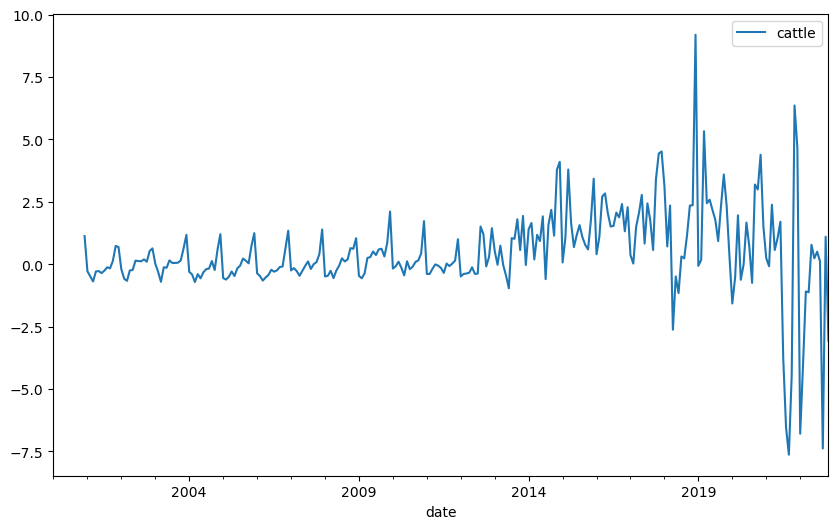

In [30]:
# Детрнединг
y_detrend = df - df.rolling(window=12).mean()
y_detrend.plot()
plt.show()

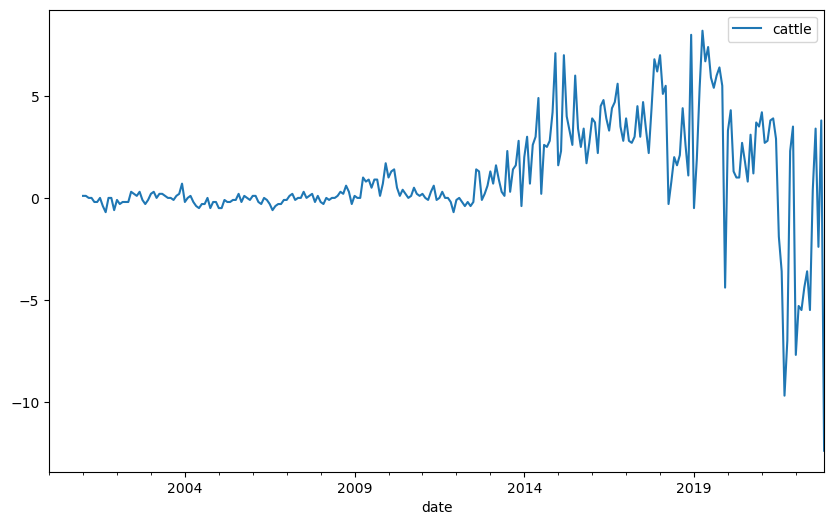

In [31]:
# Удаление сезонности
y_deseasonal = df - df.shift(12)
y_deseasonal.plot()
plt.show()

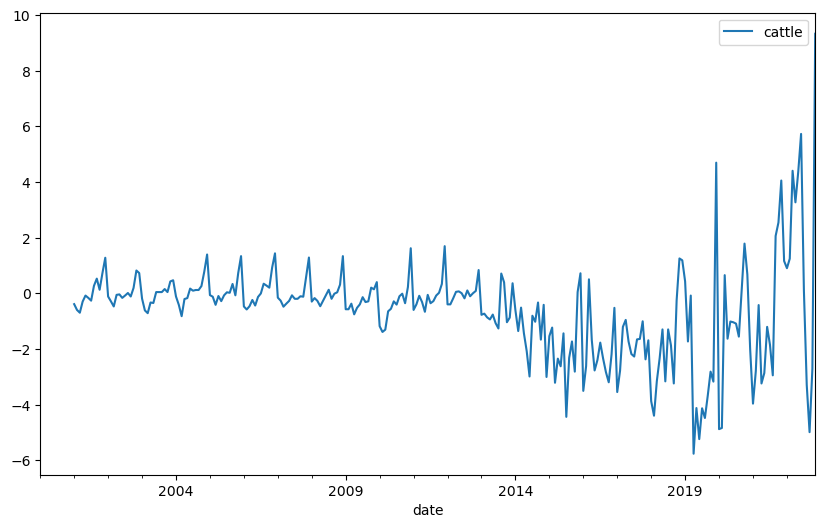

In [32]:
# Удаление тренда и сезонности
y_resid = y_detrend - y_deseasonal
y_resid.plot()
plt.show()

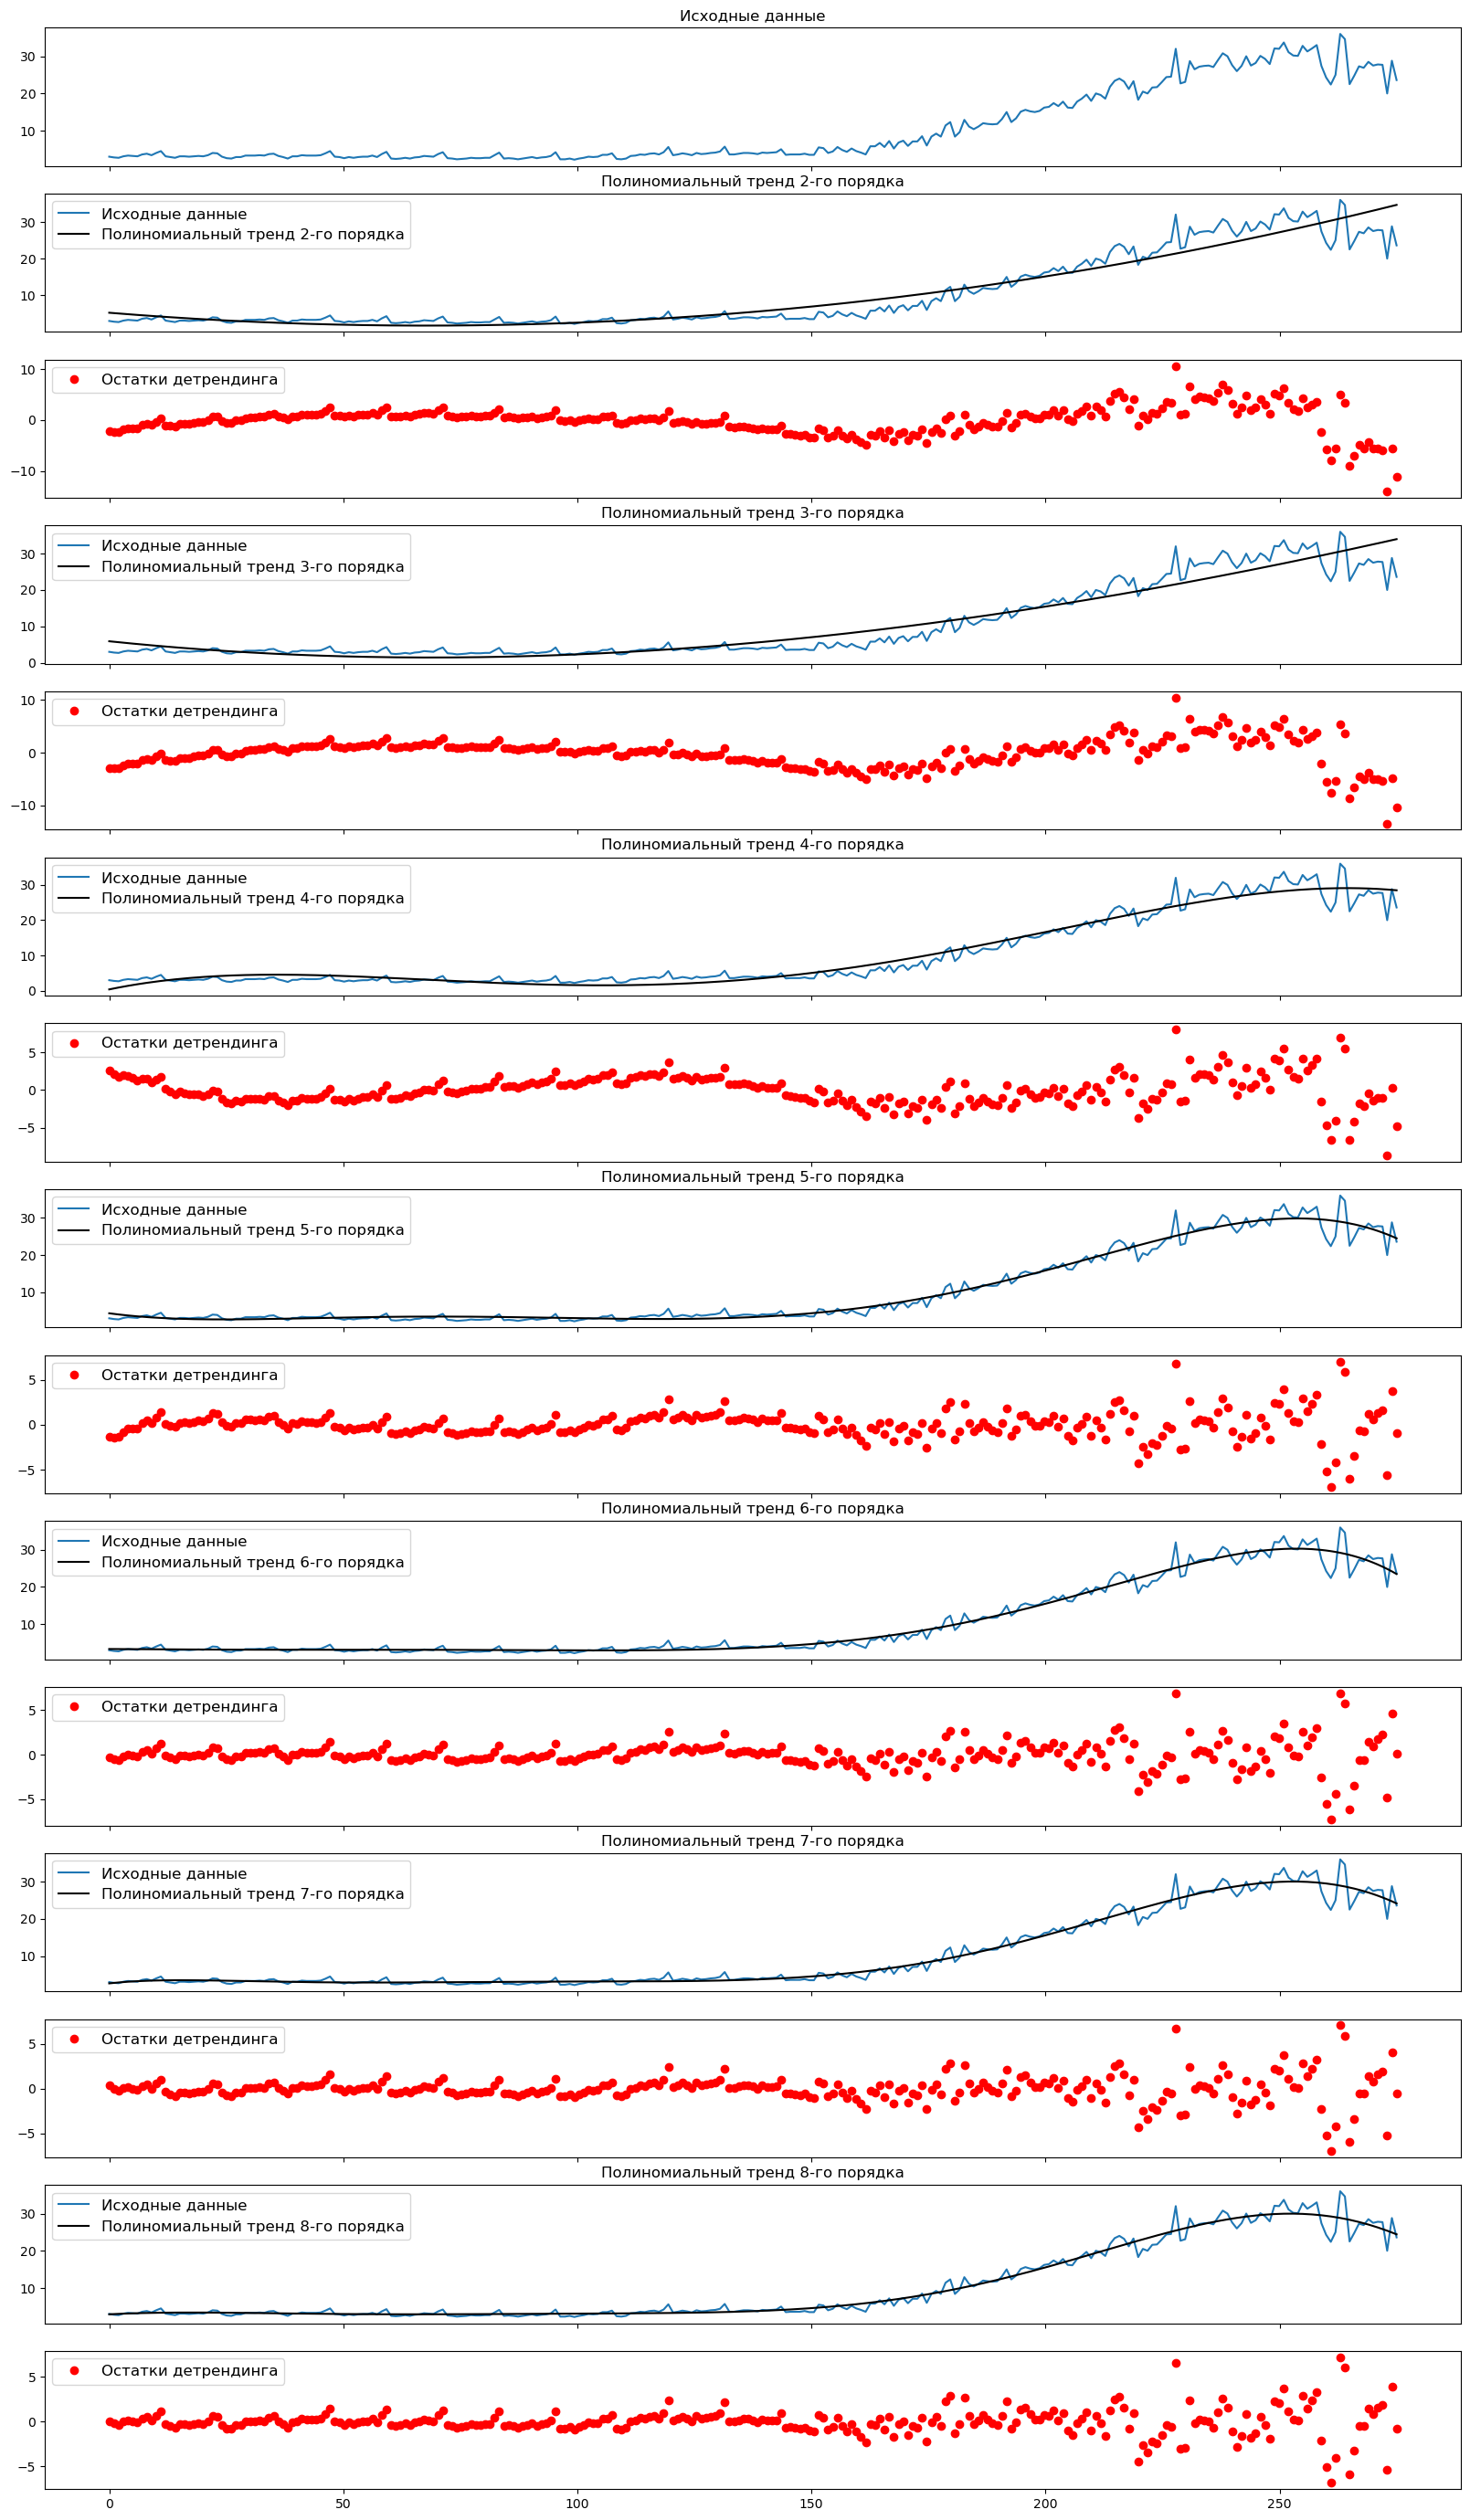

In [33]:
# Метод подбора полинома numpy polyfit
rcParams['figure.figsize'] = 20, 35
num = df["cattle"].count()
x = np.linspace(0, num, num)
y = df["cattle"]

fig, axes = plt.subplots(nrows=8+7, sharex=True)

axes[0].plot(x, y)
axes[0].set(title='Исходные данные')

for i in range(1, 8):
    model = np.polyfit(x, y, 1+i)
    predicted = np.polyval(model, x)
    axes[2 * i - 1].plot(x, y, label='Исходные данные')
    axes[2 * i - 1].plot(x, predicted, 'k-', label=f'Полиномиальный тренд {1+i}-го порядка')
    axes[2 * i - 1].set(title=f'Полиномиальный тренд {1+i}-го порядка')
    axes[2 * i].plot(x, y - predicted, 'ro', label="Остатки детрендинга")
    axes[2 * i].legend(title='', loc='upper left', fontsize=12)
    axes[2 * i - 1].legend(title='', loc='upper left', fontsize=12)

plt.show()

**Замечание:** По мере увеличения порядка полинома, мы будем более точно подгонять функцию (рискуя начать подгонять шум).

<AxesSubplot:xlabel='date'>

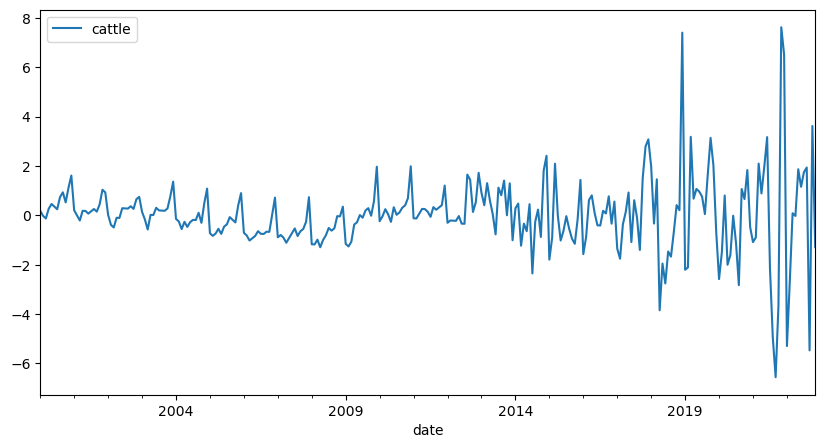

In [34]:
rcParams['figure.figsize'] = 10, 5
detrended = signal.detrend(df["cattle"], bp=[160, 250])

detrended_df = pd.DataFrame(detrended)

detrended_df.index = y_resid.index
detrended_df.columns = ["cattle"]

detrended_df.plot()

**Замечание:** данный метод не особо подходит для нелинейных временных рядов, так как в таких случаях необходимо передавать точки остановки для более корректоного результата.

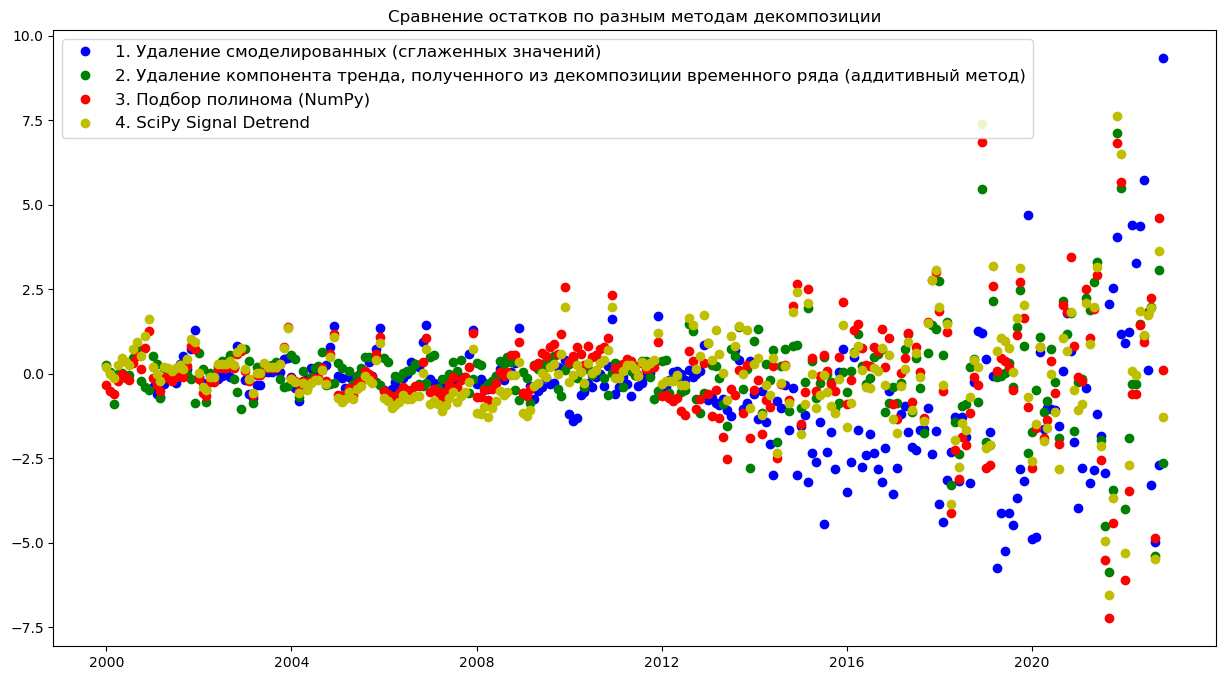

In [35]:
rcParams['figure.figsize'] = 15, 8
model = np.polyfit(x, y, 6)
predicted = np.polyval(model, x)

plt.title('Сравнение остатков по разным методам декомпозиции')
plt.plot(y_resid, "bo", label='1. Удаление смоделированных (сглаженных значений)')
plt.plot(decompose_add.resid, "go", label='2. Удаление компонента тренда, полученного из декомпозиции временного ряда (аддитивный метод)')
plt.plot(y - predicted, "ro", label='3. Подбор полинома (NumPy)')
plt.plot(detrended_df, "yo", label='4. SciPy Signal Detrend')
plt.legend(title='', loc='upper left', fontsize=12)
plt.show()

## 8. Построить ряд, очищенный от сезонности, проверить ряд на стационарность. <a class="anchor" id="8"></a>

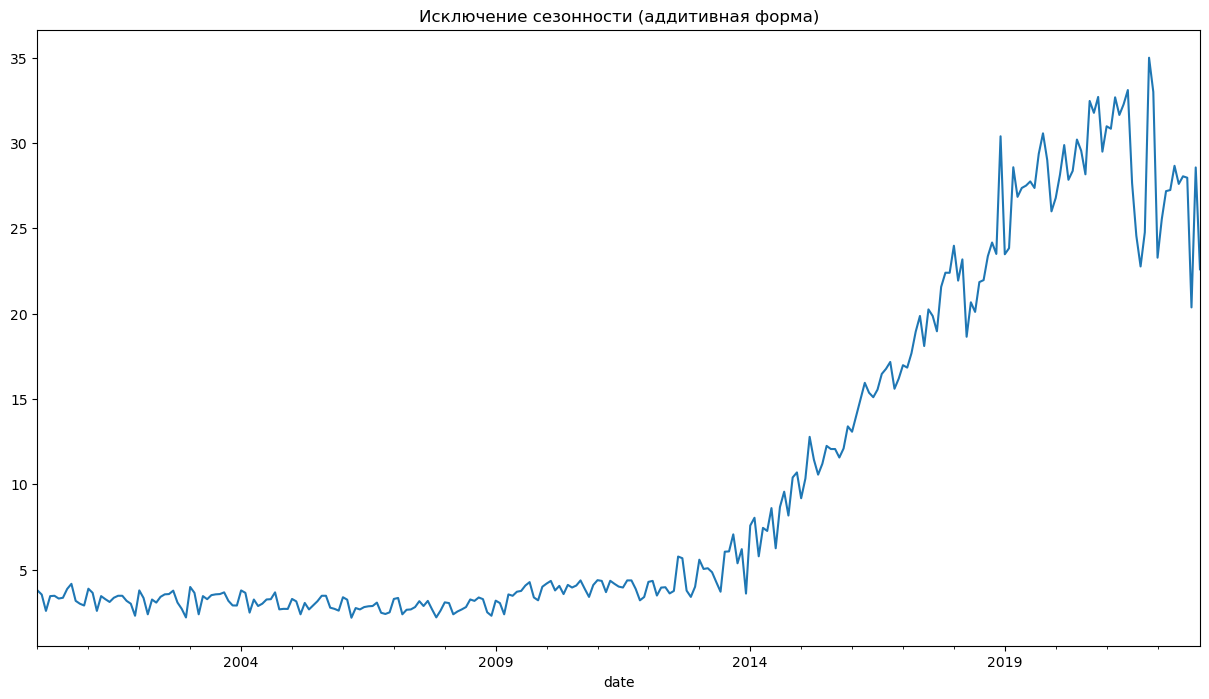

In [36]:
# Исключение сезонности
df_decompose_add["deseasonal"] = df_decompose_add["actual_values"] - df_decompose_add["seasonal"]
df_decompose_add["deseasonal"].plot()
plt.title("Исключение сезонности (аддитивная форма)")
plt.show()

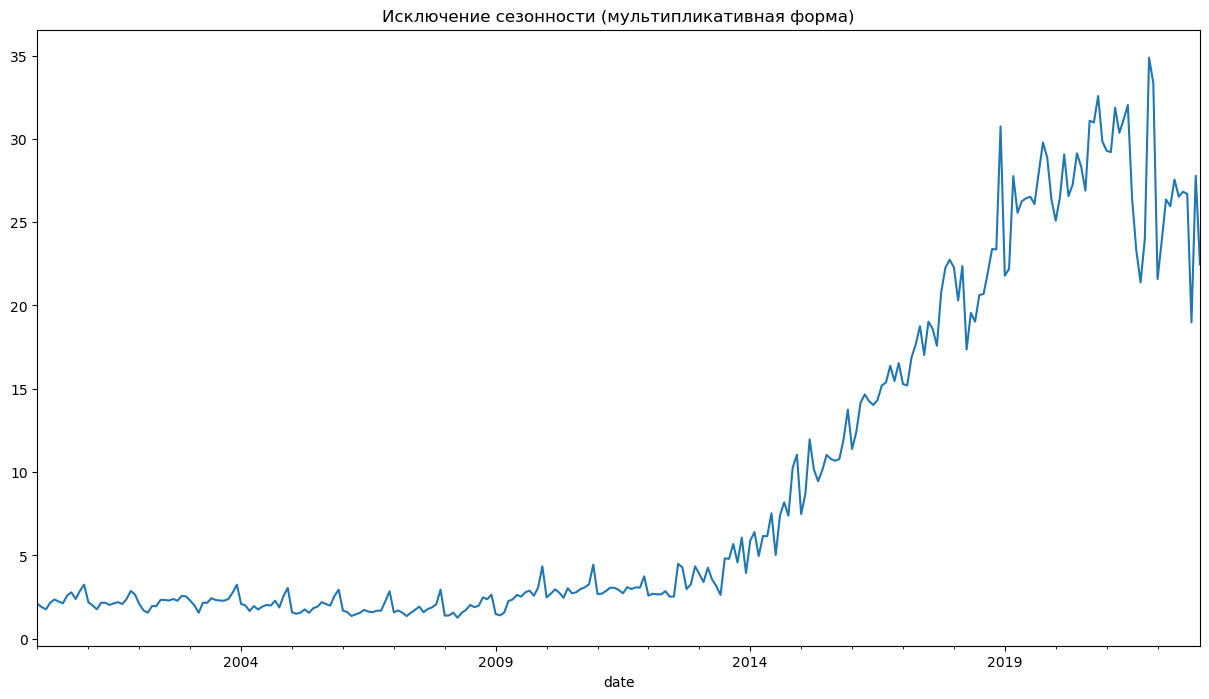

In [37]:
df_decompose_mult["deseasonal"] = df_decompose_mult["actual_values"] - df_decompose_mult["seasonal"]
df_decompose_mult["deseasonal"].plot()
plt.title("Исключение сезонности (мультипликативная форма)")
plt.show()

In [38]:
# Тест на наличие единичного корня по критерию Дики-Фуллера (аддитивная)
test_deseasonal_adfuller = adfuller(df_decompose_add['deseasonal'], autolag='AIC')
print(test_deseasonal_adfuller)

(-0.042715607160951866, 0.9548537188270968, 9, 265, {'1%': -3.4552699038400827, '5%': -2.8725092359464526, '10%': -2.5726152830188678}, 961.6682883350146)


In [39]:
print('test_adf: ', test_deseasonal_adfuller[0])
print('p-value: ', test_deseasonal_adfuller[1])
if test_deseasonal_adfuller[1] > 0.05: 
    print('Есть единичный корень, ряд нестационарный')
else:
    print('Единичного корня нет, ряд стационарный')

test_adf:  -0.042715607160951866
p-value:  0.9548537188270968
Есть единичный корень, ряд нестационарный


**Вывод: временной ряд является нестационарным**

In [40]:
# Тест на наличие единичного корня по критерию Дики-Фуллера (мультипликативная)
test_deseasonal_adfuller = adfuller(df_decompose_mult['deseasonal'], autolag='AIC')
print(test_deseasonal_adfuller)

(0.039637142451599716, 0.9616898507552196, 9, 265, {'1%': -3.4552699038400827, '5%': -2.8725092359464526, '10%': -2.5726152830188678}, 999.1967670835604)


In [41]:
print('test_adf: ', test_deseasonal_adfuller[0])
print('p-value: ', test_deseasonal_adfuller[1])
if test_deseasonal_adfuller[1] > 0.05:
    print('Есть единичный корень, ряд нестационарный')
else:
    print('Единичного корня нет, ряд стационарный')

test_adf:  0.039637142451599716
p-value:  0.9616898507552196
Есть единичный корень, ряд нестационарный


**Вывод: временной ряд является нестационарным**

## 9. Построить стационарный ряд, используя оператор последовательных разностей (дифференцирование ряда). <a class="anchor" id="9"></a>

**Тестирвоание ряда первых разностей**
$$\Delta T_{t} = T_{t} - T_{t-1}$$

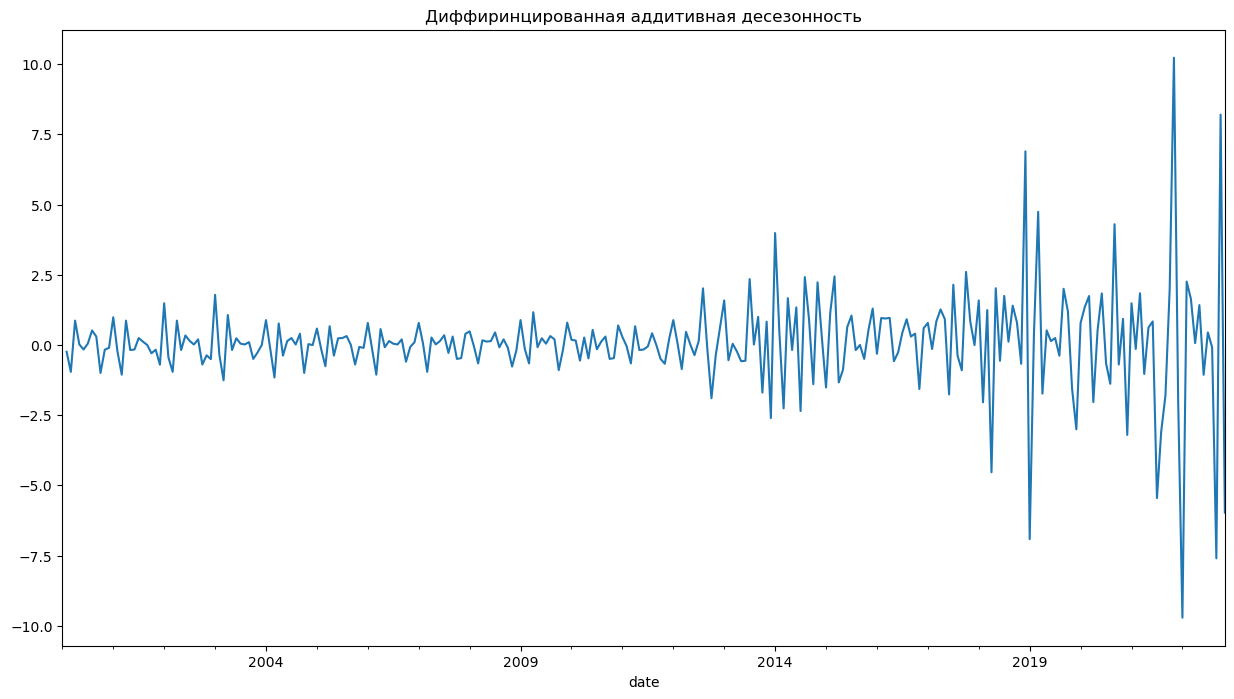

In [42]:
# Аддитивная модель
df_decompose_add['deseasonal_diff'] = df_decompose_add['deseasonal'].diff()
df_decompose_add['deseasonal_diff'].plot()
plt.title("Диффиринцированная аддитивная десезонность")
plt.show()

In [43]:
test_deseasonal_diff_adfuller = adfuller(df_decompose_add['deseasonal_diff'][1:], autolag="AIC")
print('test_adf: ', test_deseasonal_diff_adfuller[0])
print('p-value: ', test_deseasonal_diff_adfuller[1])
if test_deseasonal_diff_adfuller[1] > 0.05:
    print('Есть единичный корень, ряд нестационарный')
else:
    print('Единичного корня нет, ряд стационарный')

test_adf:  -4.7836080034638915
p-value:  5.8451837941660645e-05
Единичного корня нет, ряд стационарный


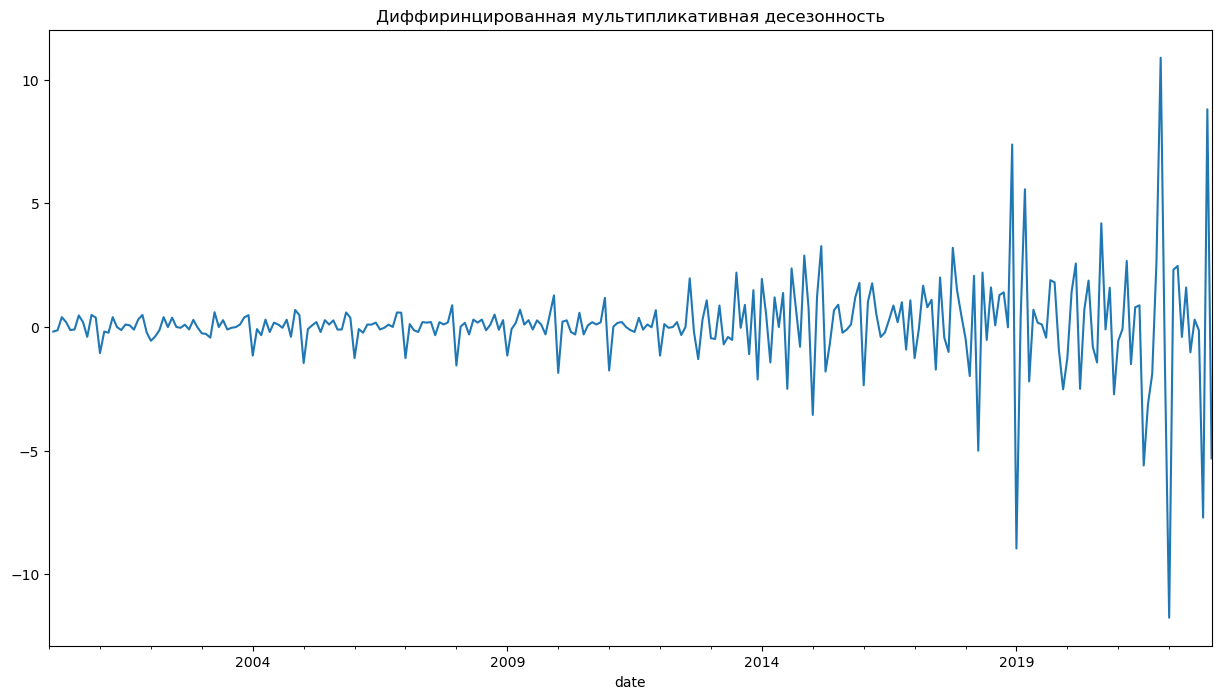

In [44]:
# Мультипликативная модель
df_decompose_mult['deseasonal_diff'] = df_decompose_mult['deseasonal'].diff()
df_decompose_mult['deseasonal_diff'].plot()
plt.title("Диффиринцированная мультипликативная десезонность")
plt.show()

In [45]:
# Тест на наличие единичного корня по критерию Дики-Фуллера
test_deseasonal_diff_adfuller = adfuller(df_decompose_mult['deseasonal_diff'][1:], autolag="AIC")
print('test_adf: ', test_deseasonal_diff_adfuller[0])
print('p-value: ', test_deseasonal_diff_adfuller[1])
if test_deseasonal_diff_adfuller[1] > 0.05:
    print('Есть единичный корень, ряд нестационарный')
else:
    print('Единичного корня нет, ряд стационарный')

test_adf:  -5.143712721318294
p-value:  1.1442547233553023e-05
Единичного корня нет, ряд стационарный


## 10. Построить ARIMA-модель, обосновать параметры выбора модели. <a class="anchor" id="10"></a>

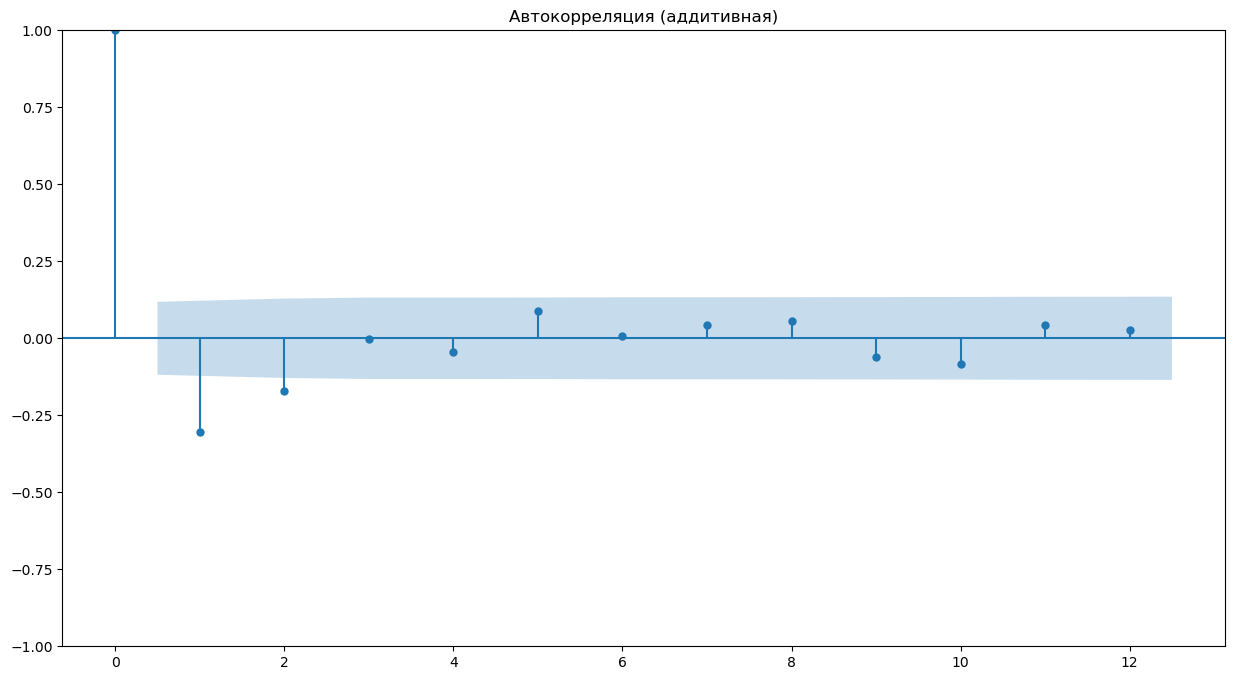

In [46]:
plot_acf(df_decompose_add["deseasonal_diff"][1:], lags=12)
plt.title("Автокорреляция (аддитивная)")
plt.show()

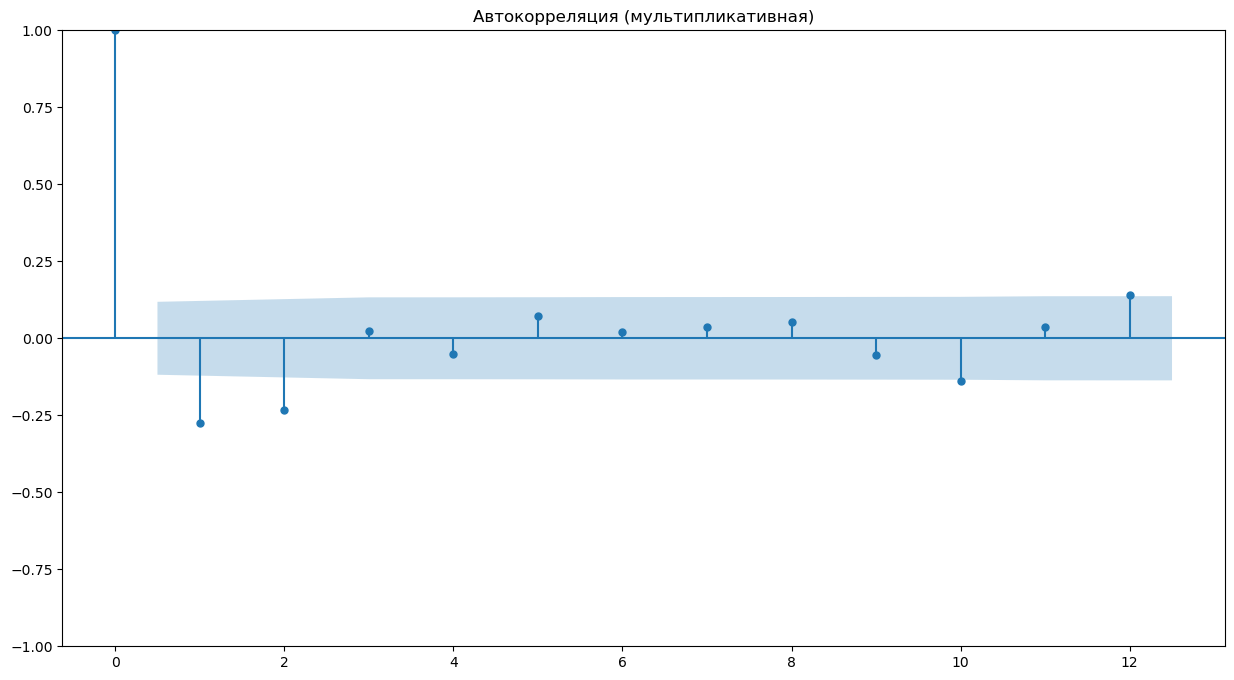

In [47]:
plot_acf(df_decompose_mult["deseasonal_diff"][1:], lags=12)
plt.title("Автокорреляция (мультипликативная)")
plt.show()

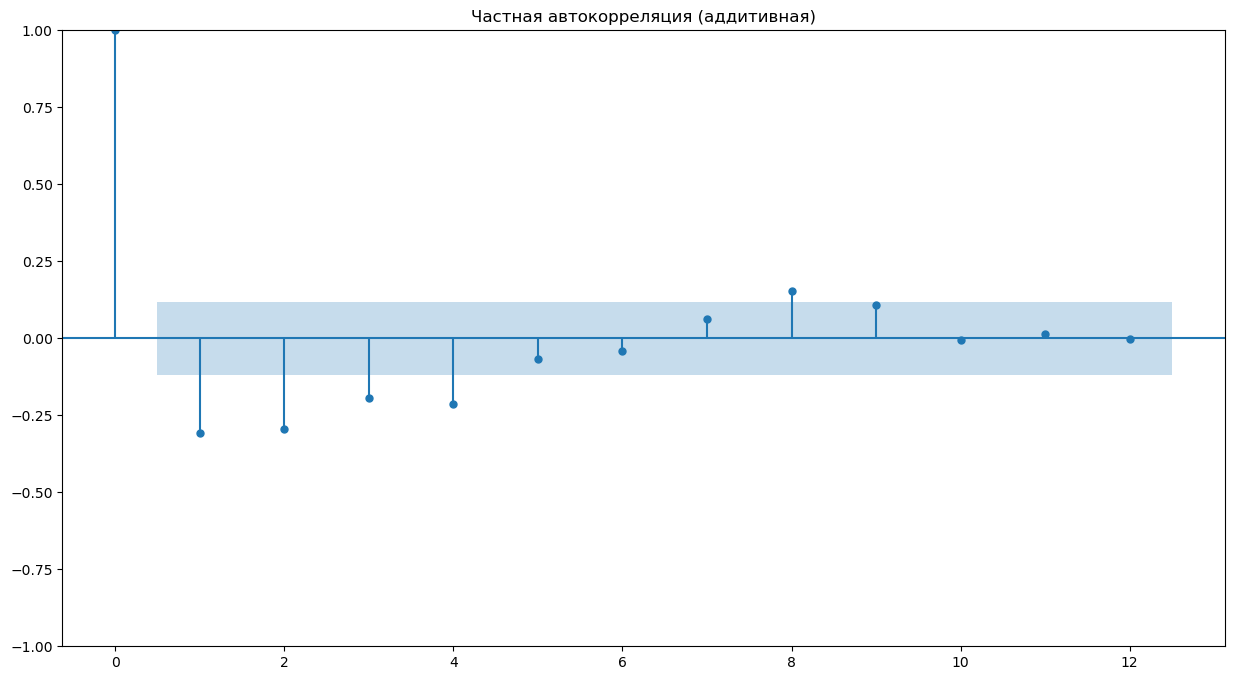

In [48]:
plot_pacf(df_decompose_add['deseasonal_diff'][1:], lags=12)
plt.title("Частная автокорреляция (аддитивная)")
plt.show()

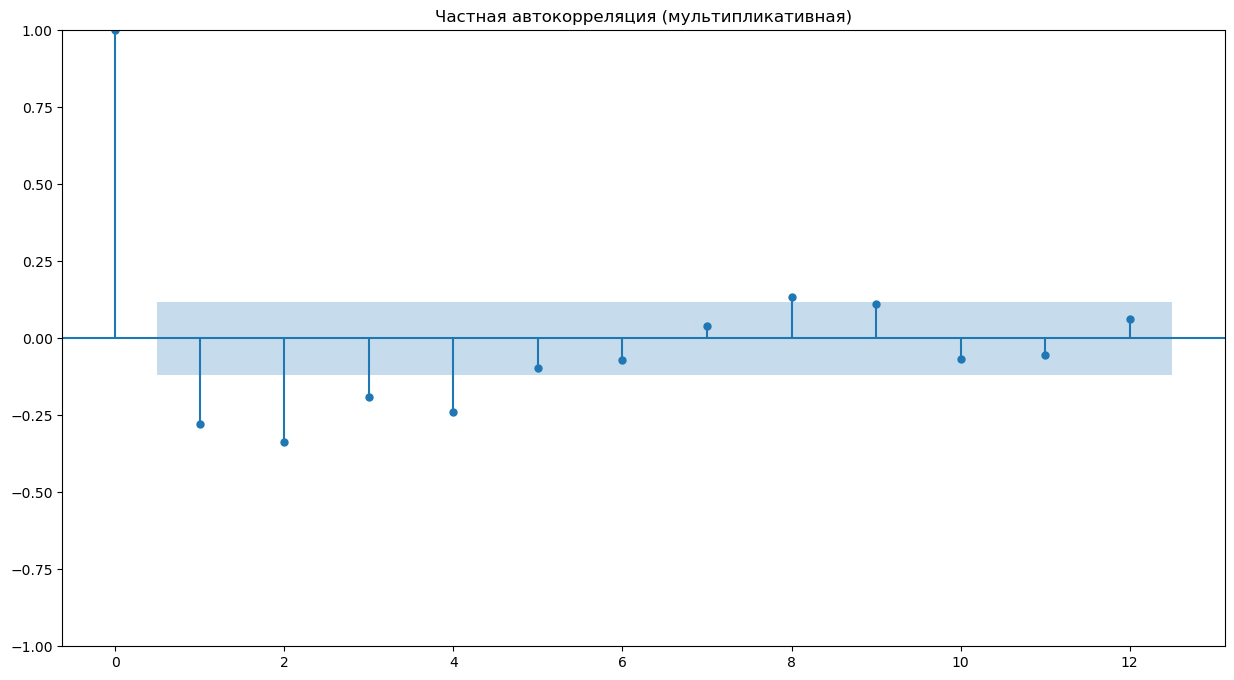

In [49]:
plot_pacf(df_decompose_mult['deseasonal_diff'][1:], lags=12)
plt.title("Частная автокорреляция (мультипликативная)")
plt.show()

In [50]:
# Инициализация и обучение модели (для аддитивной декомпозиции)
model_ARIMA_add = ARIMA(df_decompose_add.deseasonal, order=(2, 1, 2))
results_ARIMA_add = model_ARIMA_add.fit()
results_ARIMA_add.fittedvalues.head()

date
2000-01-01    0.000000
2000-02-01    3.775484
2000-03-01    3.604129
2000-04-01    3.011300
2000-05-01    3.479265
dtype: float64

In [51]:
# Вывод информации о модели
results_ARIMA_add.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             deseasonal   No. Observations:                  275
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -497.557
Date:                Fri, 13 Jan 2023   AIC                           1005.113
Time:                        11:24:35   BIC                           1023.179
Sample:                    01-01-2000   HQIC                          1012.365
                         - 11-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9369      0.097      9.677      0.000       0.747       1.127
ar.L2         -0.4354      0.049     -8.863      0.000      -0.532      -0.339
ma.L1         -1.4577      0.096    -15.260      0.000      -1.645      -1.270
ma.L2          0.7081      0.074      9.557      0.000       0.563       0.853
sigma2         2.2056      0.087     25.284      0.000       2.035       2.377
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):              1225.62
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):              27.30   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Вывод по summary:**

* Коэффициенты авторегрессии статистически значимы

* Коэффициенты скользящего среднего статистически значимы

* 0 не попадает в доверительные интервалы

**Итого: можно предположить что модель адекватна**

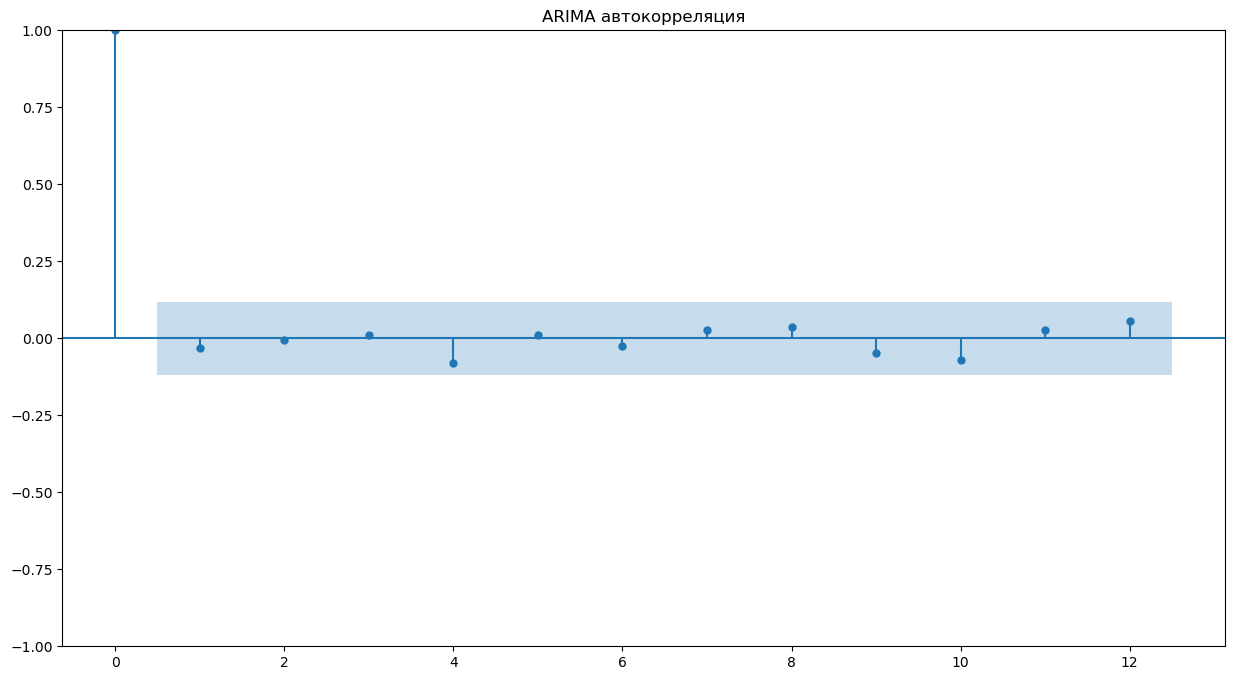

In [52]:
plot_pacf(results_ARIMA_add.resid, lags=12)
plt.title("ARIMA автокорреляция")
plt.show()

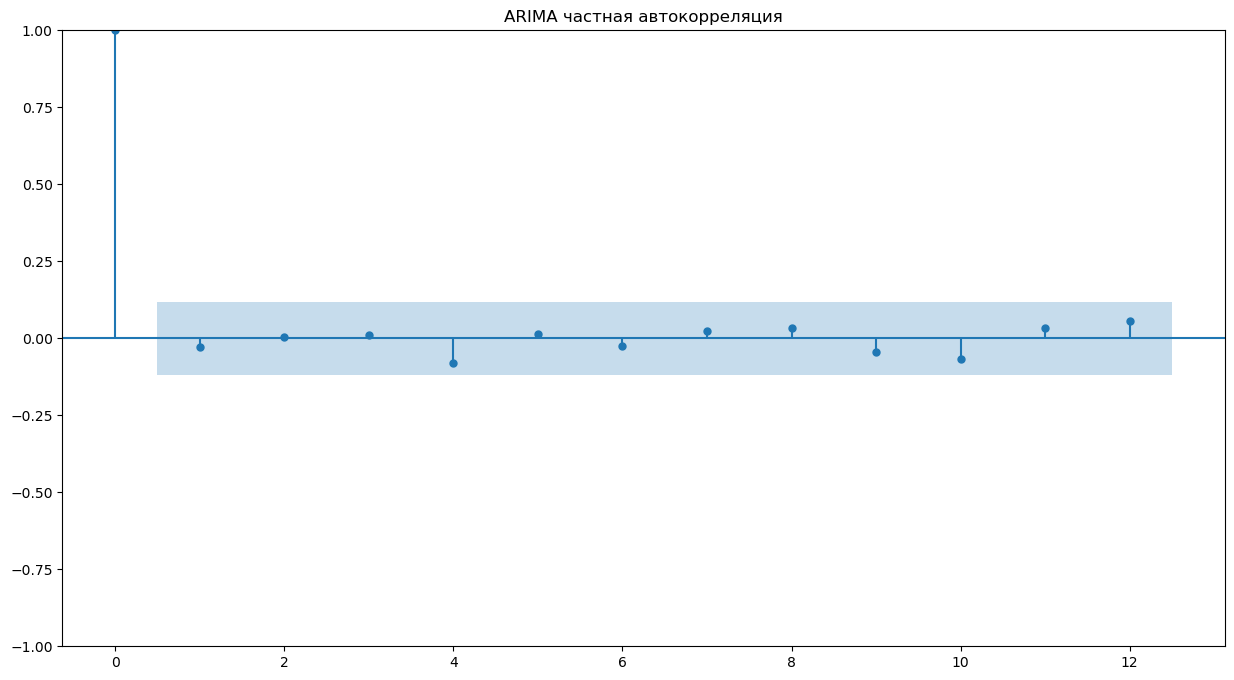

In [53]:
plot_pacf(results_ARIMA_add.resid[1:], lags=12)
plt.title("ARIMA частная автокорреляция")
plt.show()

**Вывод по аддитивной модели:**

* Исходя их автокорреляционных функций можно сделать вывод что модель адекватна, так как мы избавились от автокорреляции

**Итог: модель адекватна**

In [54]:
# Инициализация и обучение модели (для мультипликативной декомпозиции)
model_ARIMA_mult = ARIMA(df_decompose_mult.deseasonal, order=(2, 1, 1))
results_ARIMA_mult = model_ARIMA_mult.fit()
results_ARIMA_mult.fittedvalues.head()

date
2000-01-01    0.000000
2000-02-01    2.086628
2000-03-01    1.951313
2000-04-01    1.880369
2000-05-01    2.080503
dtype: float64

In [55]:
# Вывод информации о модели
results_ARIMA_mult.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             deseasonal   No. Observations:                  275
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -522.325
Date:                Fri, 13 Jan 2023   AIC                           1052.649
Time:                        11:24:35   BIC                           1067.102
Sample:                    01-01-2000   HQIC                          1058.450
                         - 11-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1200      0.052      2.319      0.020       0.019       0.221
ar.L2         -0.2130      0.035     -6.083      0.000      -0.282      -0.144
ma.L1         -0.5917      0.049    -12.107      0.000      -0.688      -0.496
sigma2         2.6452      0.099     26.770      0.000       2.452       2.839
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):              1328.11
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):              47.55   Skew:                            -0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Вывод по summary:**

* Коэффициенты авторегрессии статистически значимы

* Коэффициенты скользящего среднего статистически значимы

* 0 не попадает в доверительные интервалы

**Итого: можно предположить что модель адекватна**

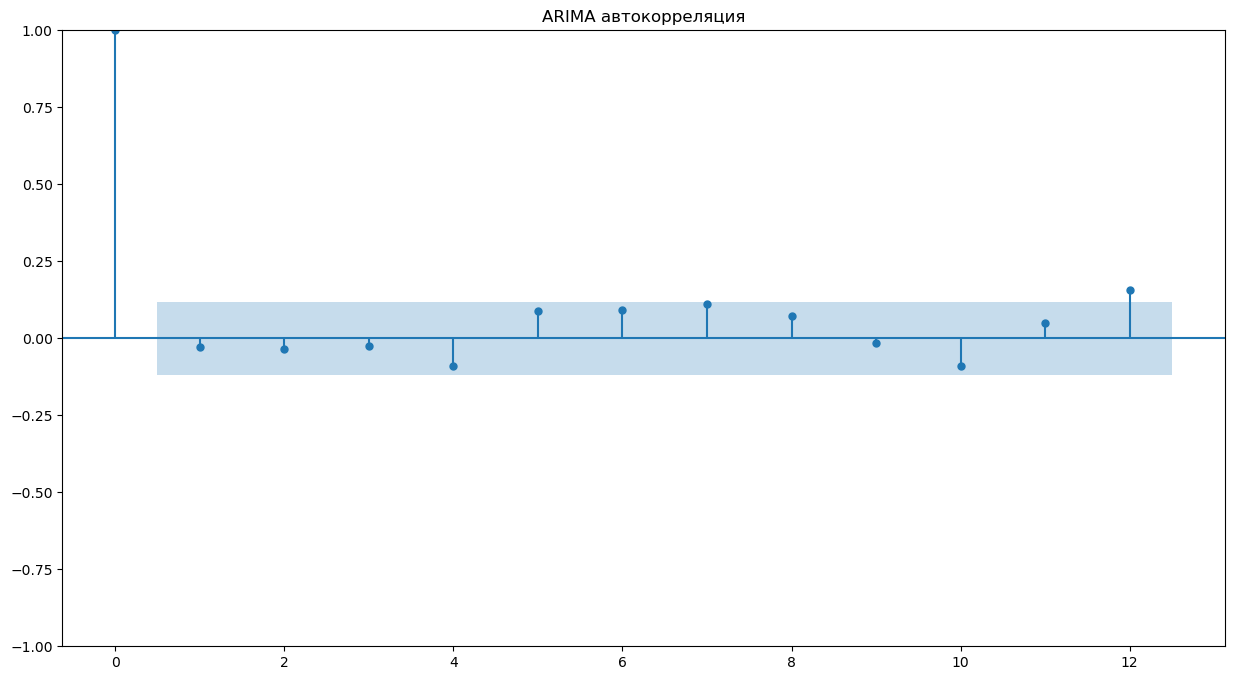

In [56]:
plot_pacf(results_ARIMA_mult.resid, lags=12)
plt.title("ARIMA автокорреляция")
plt.show()

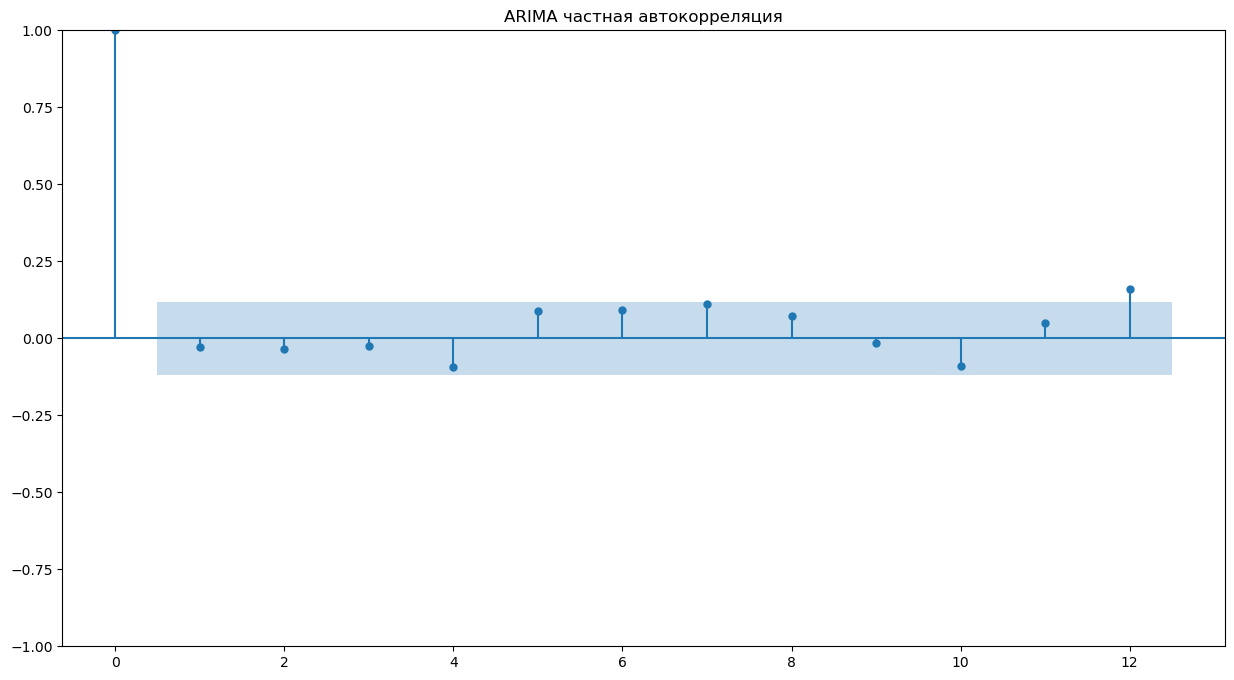

In [57]:
plot_pacf(results_ARIMA_mult.resid[1:], lags=12)
plt.title("ARIMA частная автокорреляция")
plt.show()

**Вывод по мультипликативной модели:**

* Исходя их автокорреляционных функций можно сделать вывод что модель адекватна, так как мы избавились от автокорреляции

**Итог: модель адекватна**

## 11. Провести графический анализ фактических, модельных значений, анализ остатков модели. <a class="anchor" id="11"></a>

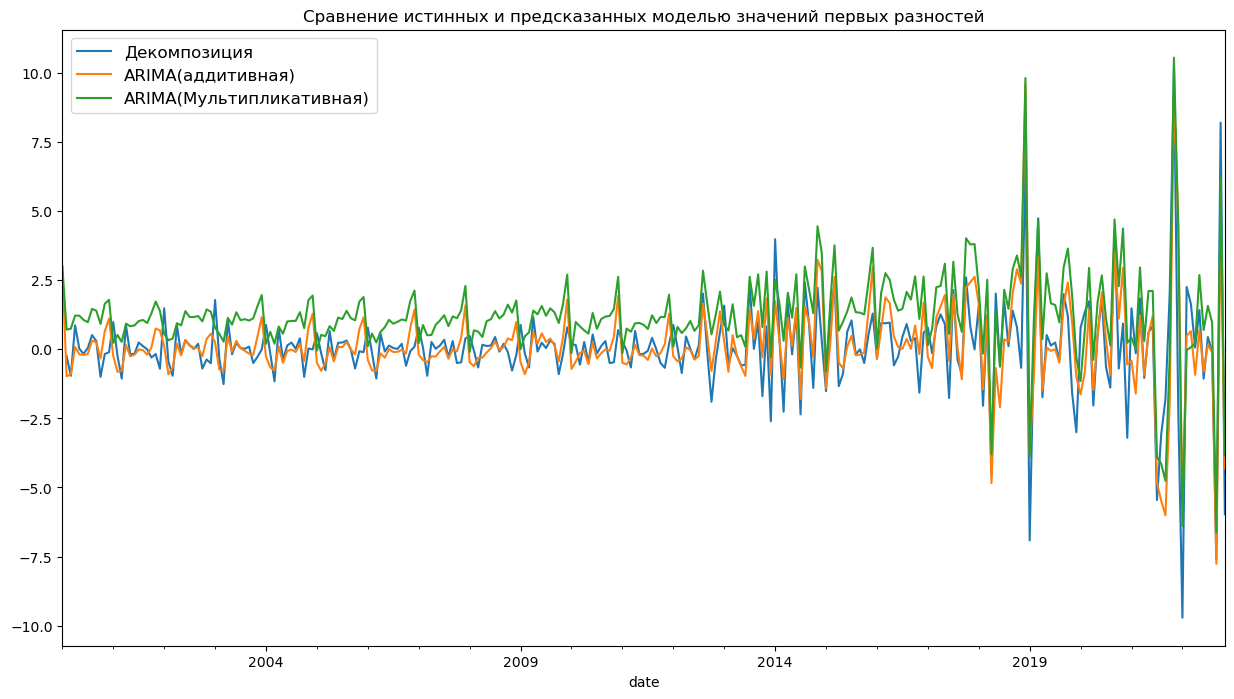

In [58]:
df_decompose_add["deseasonal_diff"].plot(label="Декомпозиция")
(df["cattle"] - results_ARIMA_add.fittedvalues).plot(label="ARIMA(аддитивная)")
(df["cattle"] - results_ARIMA_mult.fittedvalues).plot(label="ARIMA(Мультипликативная)")
plt.legend(title='', loc='upper left', fontsize=12)
plt.title("Сравнение истинных и предсказанных моделью значений первых разностей")
plt.show()

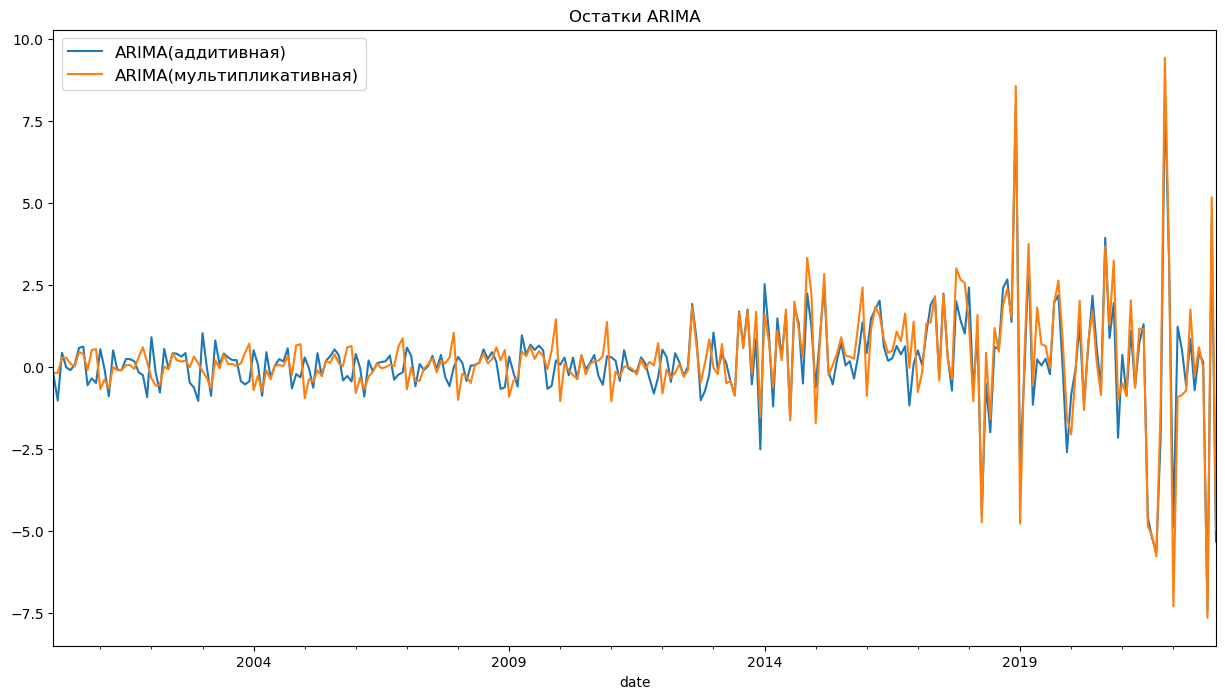

In [59]:
results_ARIMA_add.resid[1:].plot(label="ARIMA(аддитивная)")
results_ARIMA_mult.resid[1:].plot(label="ARIMA(мультипликативная)")
plt.legend(title='', loc='upper left', fontsize=12)
plt.title("Остатки ARIMA")
plt.show()

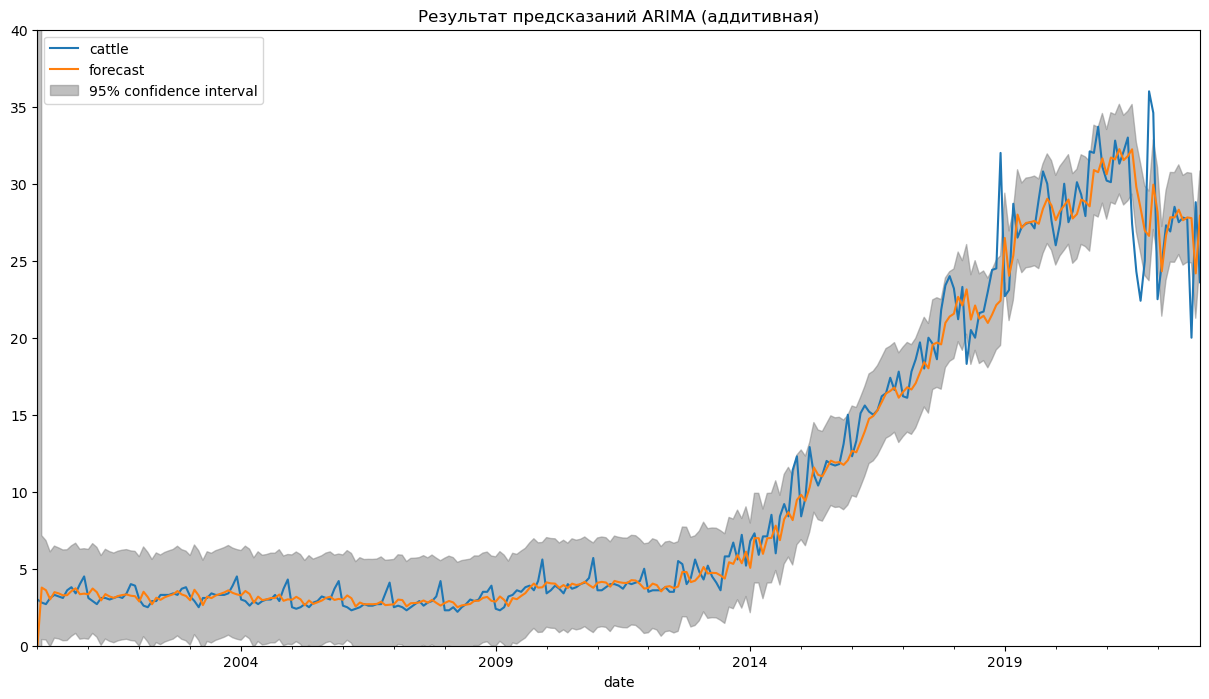

In [60]:
fig, ax = plt.subplots()
ax = plt.gca()
ax.set_ylim([0, 40])
ax = df.plot(ax=ax)
plot_predict(results_ARIMA_add, '2000', '2022', ax=ax)
plt.title("Результат предсказаний ARIMA (аддитивная)")
plt.show()

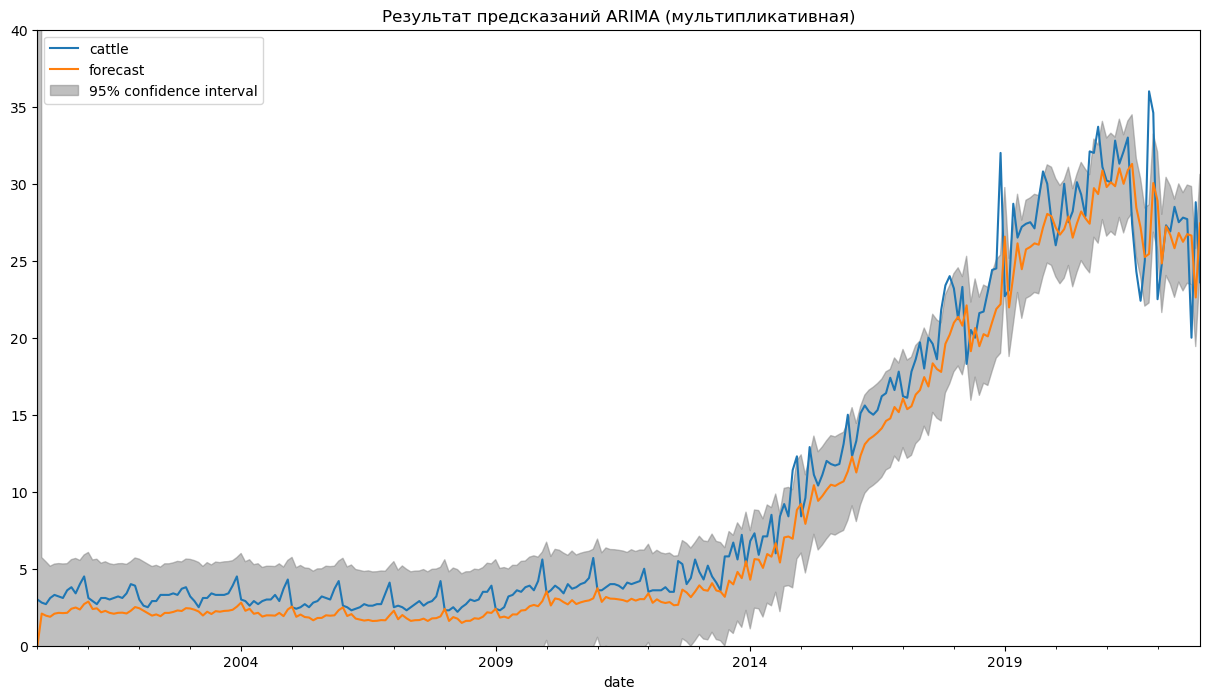

In [61]:
ig, ax = plt.subplots()
ax = plt.gca()
ax.set_ylim([0, 40])
ax = df.plot(ax=ax)
plot_predict(results_ARIMA_mult, '2000', '2022', ax=ax)
plt.title("Результат предсказаний ARIMA (мультипликативная)")
plt.show()

In [62]:
# Функции подбора параметров для ARIMA
def evaluate_arima_model(X, arima_order):
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse


def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                # try:
                rmse = evaluate_arima_model(dataset, order)
                if rmse < best_score:
                    best_score, best_cfg = rmse, order
                print('ARIMA%s RMSE=%.3f' % (order,rmse))
                # except:
                    # continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [63]:
p_values = range(3)
d_values = range(3)
q_values = range(3)
# evaluate_models(df_decompose_add.deseasonal, p_values, d_values, q_values)

## 12. Построить прогнозы. <a class="anchor" id="12"></a>

In [64]:
print("Аддитивная")
print(f'Значение сезонной компоненты для декабря -- {df_decompose_add.seasonal.iloc[11]:.2f}')
print(f'Значение сезонной компоненты для января -- {df_decompose_add.seasonal.iloc[0]:.2f}')
print(f'Значение сезонной компоненты для февраля -- {df_decompose_add.seasonal.iloc[1]:.2f}')
print("-" * 20)
print("Мультипликативная")
print(f'Значение сезонной компоненты для декабря -- {df_decompose_mult.seasonal.iloc[11]:.2f}')
print(f'Значение сезонной компоненты для января -- {df_decompose_mult.seasonal.iloc[0]:.2f}')
print(f'Значение сезонной компоненты для февраля -- {df_decompose_mult.seasonal.iloc[1]:.2f}')

Аддитивная
Значение сезонной компоненты для декабря -- 1.61
Значение сезонной компоненты для января -- -0.78
Значение сезонной компоненты для февраля -- -0.73
--------------------
Мультипликативная
Значение сезонной компоненты для декабря -- 1.26
Значение сезонной компоненты для января -- 0.91
Значение сезонной компоненты для февраля -- 0.90


In [65]:
print("Аддитивная")
print(f'Прогнозное значение ряда на декабрь равно {results_ARIMA_add.forecast(steps=1)[0] + df_decompose_add.seasonal.iloc[11]:.2f}')
print(f'Прогнозное значение ряда на январь равно {results_ARIMA_add.forecast(steps=2)[0] + df_decompose_add.seasonal.iloc[0]:.2f}')
print(f'Прогнозное значение ряда на февраль равно {results_ARIMA_add.forecast(steps=3)[0] + df_decompose_add.seasonal.iloc[1]:.2f}')
print("-" * 20)
print("Мультипликативная")
print(f'Прогнозное значение ряда на декабрь равно {results_ARIMA_mult.forecast(steps=1)[0] * df_decompose_mult.seasonal.iloc[11]:.2f}')
print(f'Прогнозное значение ряда на январь равно {results_ARIMA_mult.forecast(steps=2)[0] * df_decompose_mult.seasonal.iloc[0]:.2f}')
print(f'Прогнозное значение ряда на февраль равно {results_ARIMA_mult.forecast(steps=3)[0] * df_decompose_mult.seasonal.iloc[1]:.2f}')

Аддитивная
Прогнозное значение ряда на декабрь равно 25.91
Прогнозное значение ряда на январь равно 23.52
Прогнозное значение ряда на февраль равно 23.57
--------------------
Мультипликативная
Прогнозное значение ряда на декабрь равно 28.73
Прогнозное значение ряда на январь равно 20.91
Прогнозное значение ряда на февраль равно 20.60


### Использование библиотеки sktime <a class="anchor" id="12.1"></a>

In [66]:
# Создаем датасет с предсказанными значениями
will = pd.DataFrame(index=pd.PeriodIndex(pd.date_range("2022-12", periods=3, freq="M")))
will["cattle"] = [results_ARIMA_add.forecast(steps=1)[0] + df_decompose_add.seasonal.iloc[11], results_ARIMA_add.forecast(steps=2)[0] + df_decompose_add.seasonal.iloc[0], results_ARIMA_add.forecast(steps=3)[0] + df_decompose_add.seasonal.iloc[1]]
will

cattle
2022-12  25.909065
2023-01  23.524003
2023-02  23.566653

In [67]:
# Функция вывода спрогнозированных данных и метрик модели
def metric_forecaster(forecaster, test):
    y_pred = forecaster.predict(fh=test.index)
    plot_series(y_pred, test, labels=["Спрогнозированное", "Действительное"])
    plt.show()
    print(f"Среднеквадратичная ошибка (MSE): {mean_squared_error(y_pred, test):0.2f}")
    print(f"Среднеквадратичная геометрическая ошибка (GMSE): {geometric_mean_squared_error(y_pred, test):0.2f}")

#### Вариант с делением на обучающую и тестовую выборки

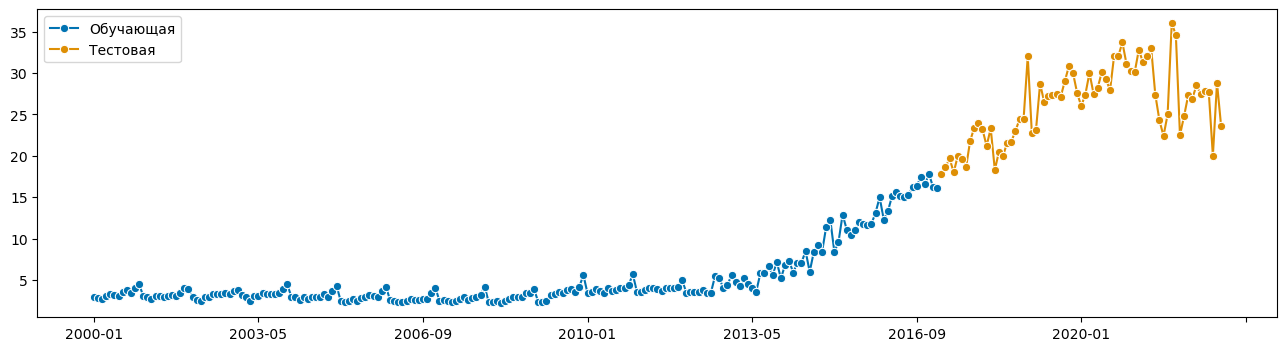

In [68]:
# Подготоваливаем обучающую и тестовую выборки
y = df["cattle"]
y_sktime = y.reset_index()
y_sktime["date"] = pd.to_datetime(y.reset_index()["date"], errors='coerce').dt.to_period('m')
y_sktime = y_sktime.set_index("date")

y_train, y_test = temporal_train_test_split(y_sktime)
plot_series(y_train, y_test, labels=["Обучающая", "Тестовая"])
plt.show()

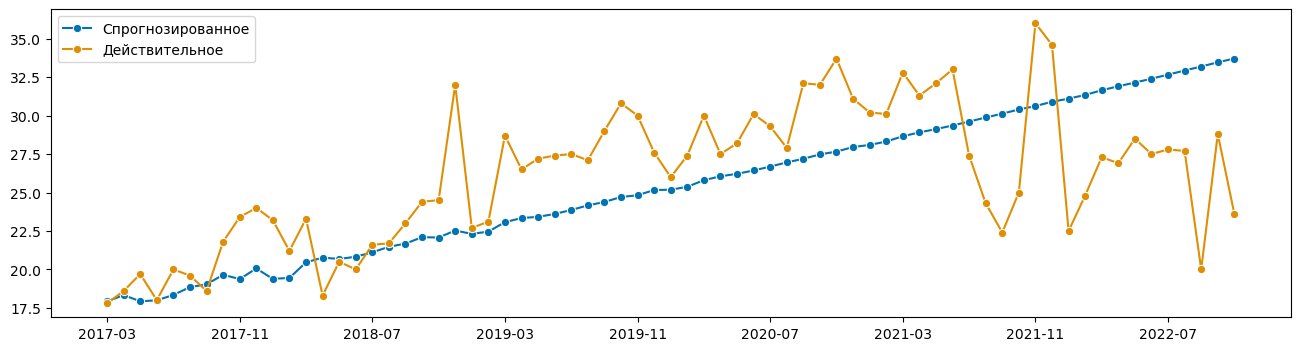

Среднеквадратичная ошибка (MSE): 18.41
Среднеквадратичная геометрическая ошибка (GMSE): 5.37


In [69]:
# SARIMAX
forecaster = SARIMAX(order=(2, 1, 1), trend="t", seasonal_order=(1, 0, 0, 12))
forecaster.fit(y_train)

metric_forecaster(forecaster, y_test)

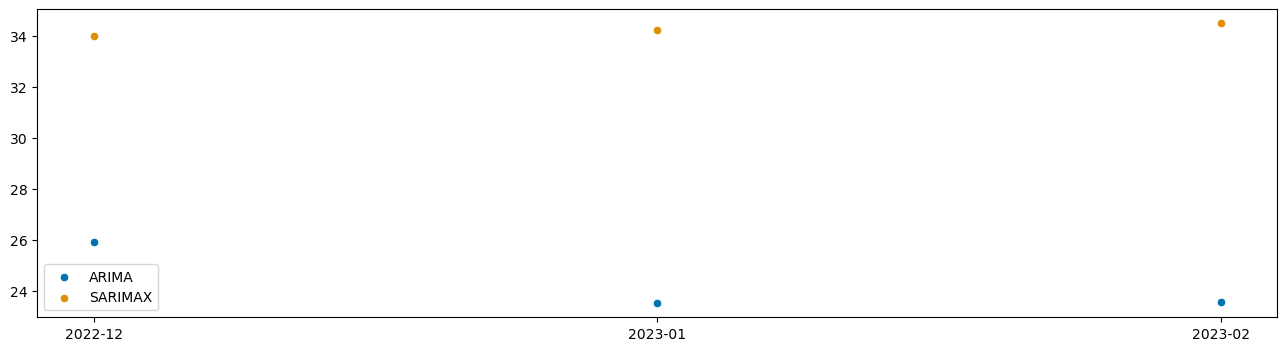

In [70]:
# Сравнение предсказаний ARIMA и SARIMAX будующих 3 месяцев
y_pred = forecaster.predict(fh=will.index)
plot_series(will, y_pred, labels=["ARIMA", "SARIMAX"])
plt.show()

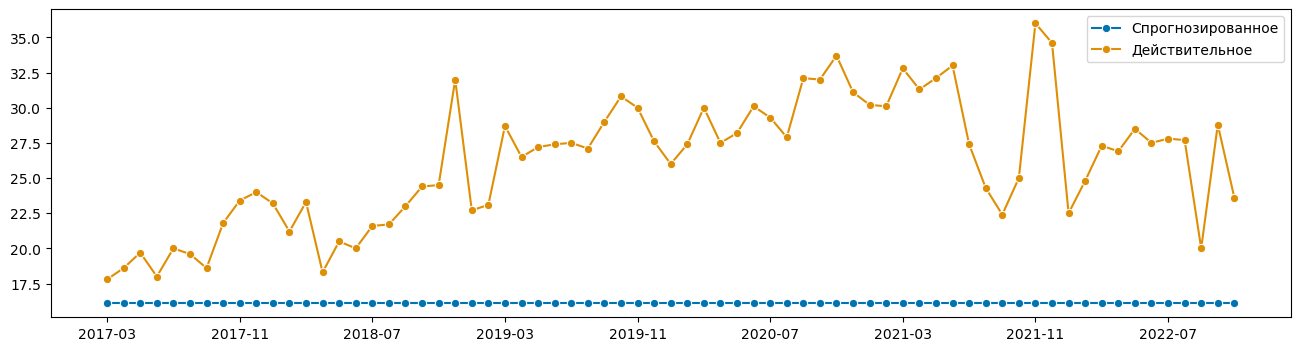

Среднеквадратичная ошибка (MSE): 120.86
Среднеквадратичная геометрическая ошибка (GMSE): 76.22


In [71]:
forecaster = NaiveForecaster(strategy="last", sp=1)
forecaster.fit(y_train)

metric_forecaster(forecaster, y_test)

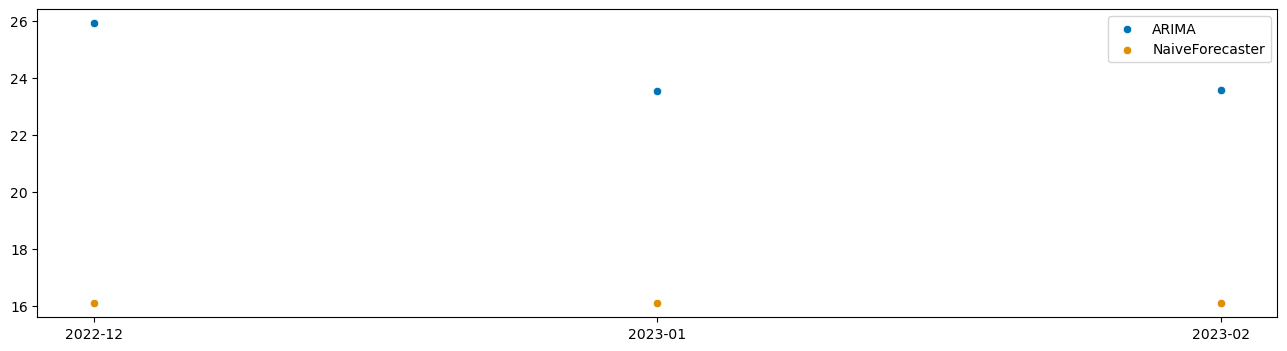

In [72]:
# Сравнение предсказаний ARIMA и NaiveForecaster будующих 3 месяцев
y_pred = forecaster.predict(fh=will.index)
plot_series(will, y_pred, labels=["ARIMA", "NaiveForecaster"])
plt.show()

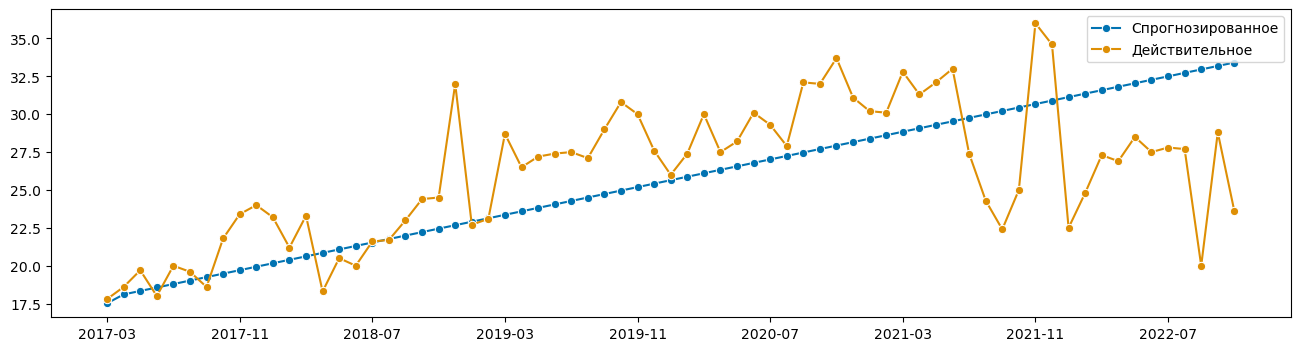

Среднеквадратичная ошибка (MSE): 17.14
Среднеквадратичная геометрическая ошибка (GMSE): 4.53


In [73]:
forecaster = AutoARIMA(sp=1, suppress_warnings=True)
forecaster.fit(y_train)
metric_forecaster(forecaster, y_test)

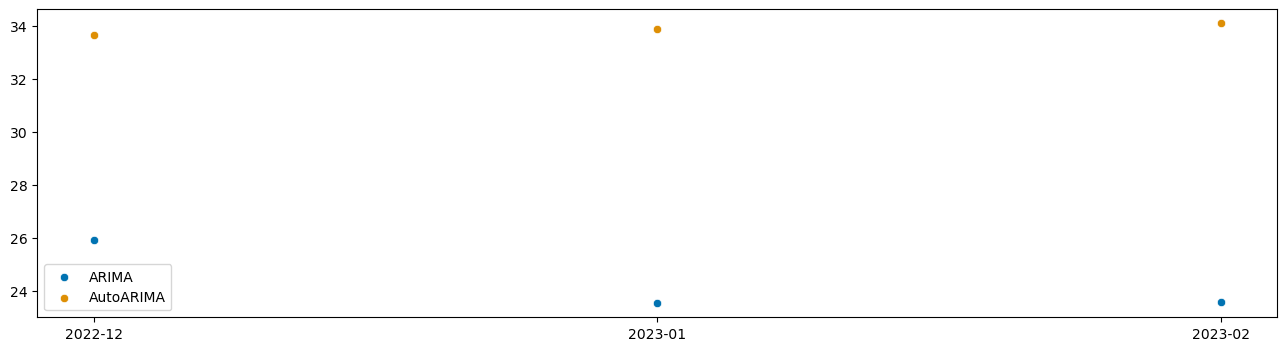

In [74]:
# Сравнение предсказаний ARIMA и AutoARIMA будующих 3 месяцев
y_pred = forecaster.predict(fh=will.index)
plot_series(will, y_pred, labels=["ARIMA", "AutoARIMA"])
plt.show()

#### Вариант с обучением на всей выборке

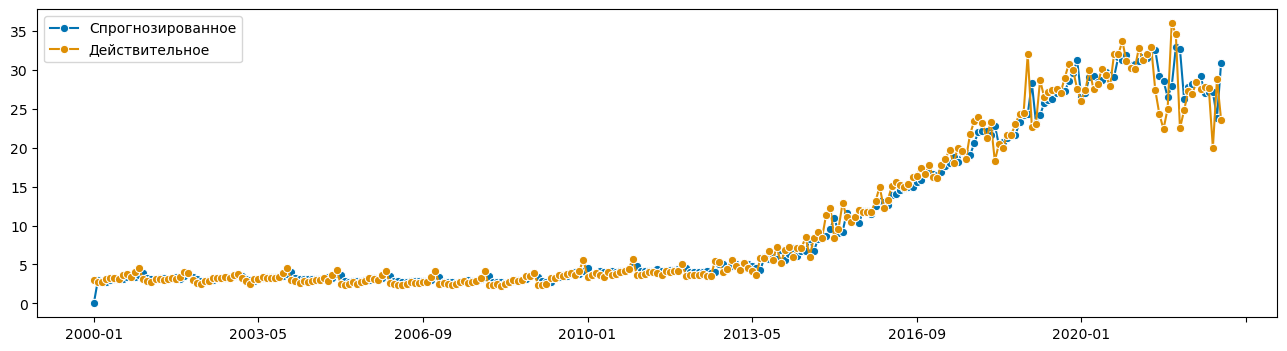

Среднеквадратичная ошибка (MSE): 2.71
Среднеквадратичная геометрическая ошибка (GMSE): 0.15


In [75]:
# SARIMAX
forecaster = SARIMAX(order=(1, 1, 1), trend="t", seasonal_order=(1, 0, 0, 12))
forecaster.fit(y_sktime)

metric_forecaster(forecaster, y_sktime)

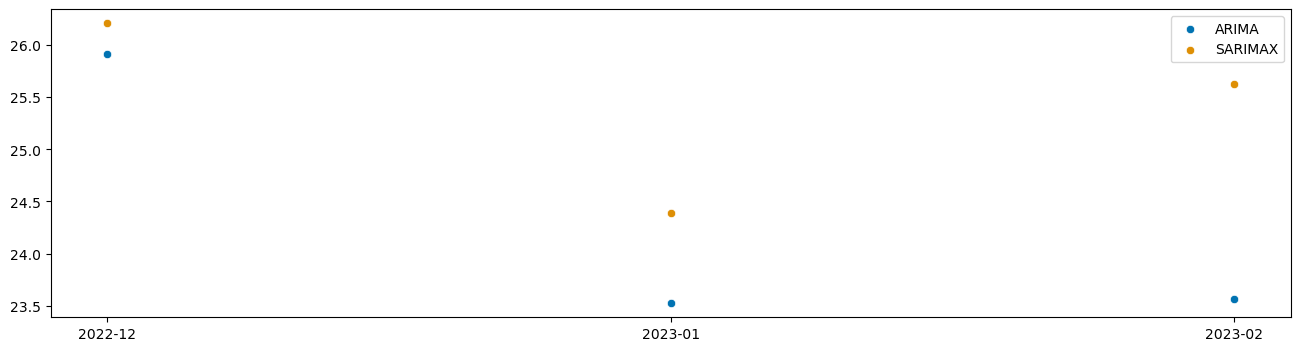

In [76]:
# Сравнение предсказаний ARIMA и SARIMAX будующих 3 месяцев
y_pred = forecaster.predict(fh=will.index)
plot_series(will, y_pred, labels=["ARIMA", "SARIMAX"])
plt.show()

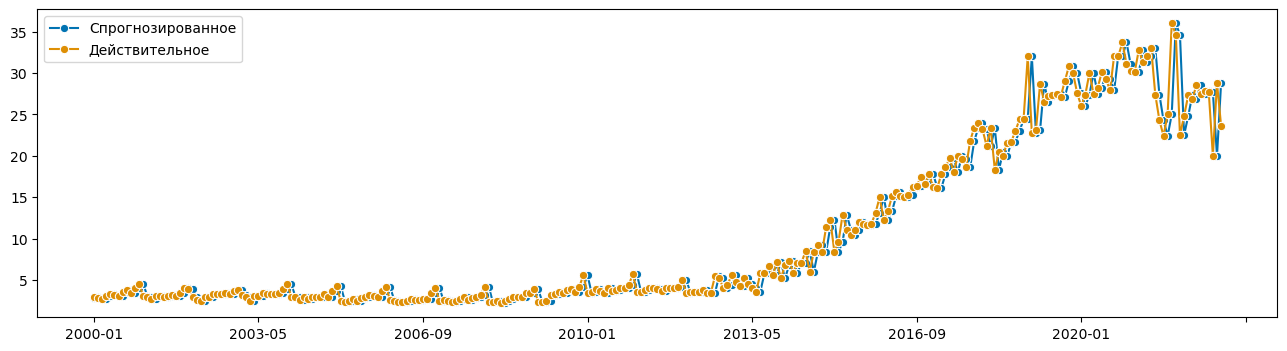

Среднеквадратичная ошибка (MSE): 3.59
Среднеквадратичная геометрическая ошибка (GMSE): 0.00


In [77]:
forecaster = NaiveForecaster(strategy="last", sp=1)
forecaster.fit(y_sktime)

metric_forecaster(forecaster, y_sktime)

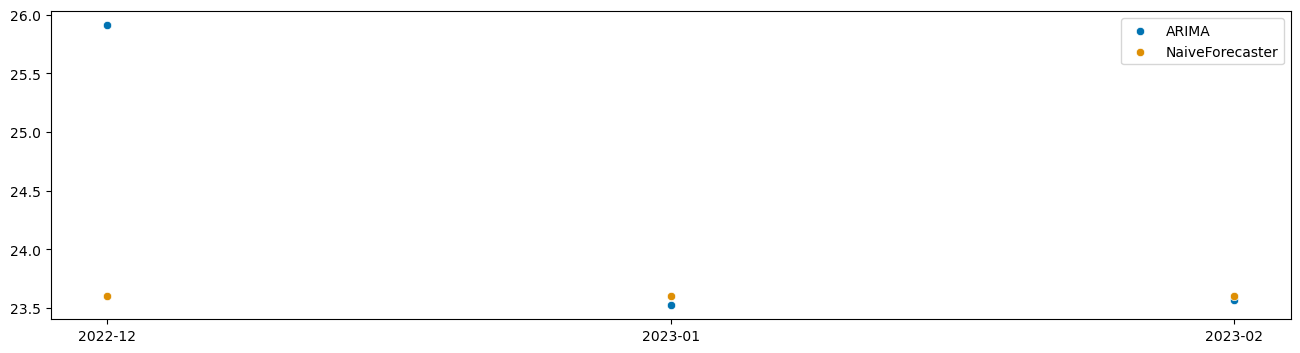

In [78]:
# Сравнение предсказаний ARIMA и NaiveForecaster будующих 3 месяцев
y_pred = forecaster.predict(fh=will.index)
plot_series(will, y_pred, labels=["ARIMA", "NaiveForecaster"])
plt.show()

In [79]:
forecaster = AutoARIMA(sp=1, suppress_warnings=True)
forecaster.fit(y_sktime)
# AutoARIMA может предсказать только будующие значения, которых не было при обучении

AutoARIMA(suppress_warnings=True)

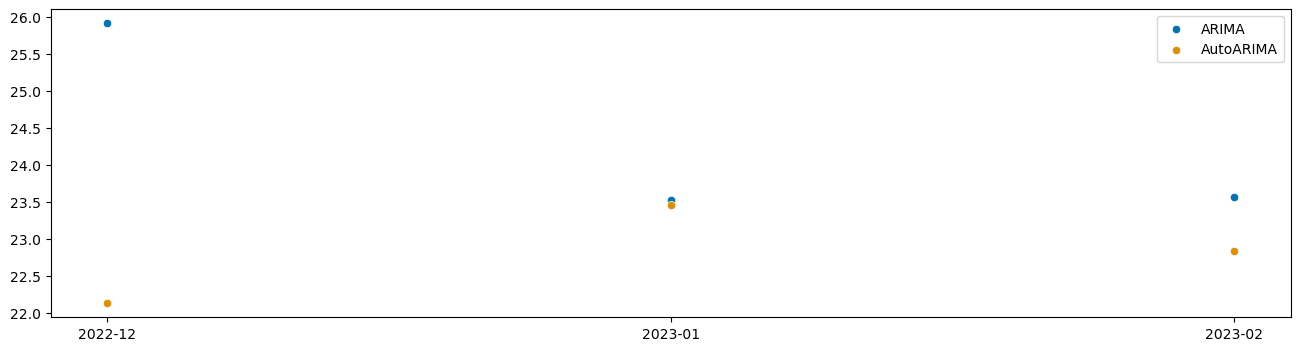

In [80]:
# Сравнение предсказаний ARIMA и AutoARIMA будующих 3 месяцев
y_pred = forecaster.predict(fh=will.index)
plot_series(will, y_pred, labels=["ARIMA", "AutoARIMA"])
plt.show()